In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import os
from typing import List, Dict, Union
from pydantic import BaseModel, Field
from langchain.output_parsers import PydanticOutputParser
from openai import OpenAI
from metrics import *
from agent import *
from prompt import *

In [22]:
df.columns

Index(['Unnamed: 0', 'patient_filename', 't', 'text', 'type'], dtype='object')

In [8]:
for i in range(10):
    path = f"/home/yl3427/cylab/selfCorrectionAgent/result/n03_memory_dataset{i}.csv"
    df = pd.read_csv(path).drop(columns=["t"])
    df.to_csv(path, index=False)

# Filter data for Qualitative Analysis

### T14

In [21]:
t_train_df = pd.read_csv("/home/yl3427/cylab/selfCorrectionAgent/result/t14_memory_dataset0.csv")
memory_dict_t = {}
for idx, row in t_train_df.iterrows():
    memory_dict_t[f"{idx+1}"] = row['cmem_t_memory_str']


for i in ['10', '20', '30', '40', '50', '60', '70', '80', '90', '100']:
    print(f"Memory at {i}")
    print(memory_dict_t[i])
    print()
    print(len(memory_dict_t[i]))
    print("--------------------------------------------------")

Memory at 10
T1: If the tumor size is 2 cm or less, then the T stage is T1.
T2: If the tumor size is more than 2 cm but not more than 5 cm, then the T stage is T2.
T3: If the tumor size is more than 5 cm, then the T stage is T3.
T4: If the tumor has direct extension to the chest wall or skin, then the T stage is T4, regardless of the size of the tumor.

341
--------------------------------------------------
Memory at 20
T1: If the tumor is invasive ductal carcinoma and the tumor size is 2 cm or less, then the T stage is T1.
T2: If the tumor is invasive ductal carcinoma and the tumor size is more than 2 cm but not more than 5 cm, then the T stage is T2.
T3: If the tumor is invasive ductal carcinoma and the tumor size is more than 5 cm, then the T stage is T3.
T4: If the tumor is invasive ductal carcinoma and has direct extension to the chest wall or skin, then the T stage is T4.

466
--------------------------------------------------
Memory at 30
T1: If the tumor is invasive and the tum

In [20]:
t_test_df = pd.read_csv(f"/home/yl3427/cylab/selfCorrectionAgent/0718_t14_dynamic_test_0_outof_10runs.csv").sort_values(by="patient_filename")
t_zscot_df = pd.read_csv("/home/yl3427/cylab/selfCorrectionAgent/result/0716/t14_zs_test_800.csv").sort_values(by="patient_filename")

split_ids = t_test_df.patient_filename
t_zscot_df = t_zscot_df[t_zscot_df.patient_filename.isin(split_ids)]
for memory_patient, zs_patient in zip(t_test_df.patient_filename, t_zscot_df.patient_filename):
    assert memory_patient == zs_patient

output_dir = "/secure/shared_data/studio_label/kepa_error_t"
os.makedirs(output_dir, exist_ok=True)

ids_set = set()
for idx, (filename, label, memory_ans, zs_ans, memory_rsn, zs_rsn) in enumerate(zip(t_test_df.patient_filename, t_test_df.t, t_test_df.cmem_t_40reports_ans_str, t_zscot_df.zs_t_ans_str, t_test_df.cmem_t_40reasoning, t_zscot_df.zs_t_reasoning)):
    # if (f"T{label+1}" in zs_ans.upper()) and (f"T{label+1}" in memory_ans.upper()): # cases where both are correct
    # if (f"T{label+1}" not in zs_ans.upper()) and (f"T{label+1}" in memory_ans.upper()): # cases where only memory was correct
    if (f"T{label+1}" in zs_ans.upper()) and (f"T{label+1}" not in memory_ans.upper()): # cases where only zs was correct
    # if (f"T{label+1}" not in zs_ans.upper()) and (f"T{label+1}" not in memory_ans.upper()): # cases where both were wrong
        ids_set.add(filename)
        data = {
            "data": {
                "humanMachineDialogue": [
                    {"author": "Patient filename", "text": filename},
                    {"author": "Memory Reasoning", "text": memory_rsn},
                    {"author": "ZS Reasoning", "text": zs_rsn}, 
                    {"author": "Answer", "text": f"T{label+1}"},
                    {"author": "Memory Answer", "text": memory_ans},
                    {"author": "ZS Answer", "text": zs_ans}
                ]
            }
        }
        
        file_name = f"kepa_error_t_{idx}.json"
        file_path = os.path.join(output_dir, file_name)
        with open(file_path, 'w') as json_file:
            json.dump(data, json_file, indent=4)

In [22]:
len(ids_set)

21

### N03

In [15]:
len(memory_dict_n)

100

In [38]:
n_train_df = pd.read_csv("/home/yl3427/cylab/selfCorrectionAgent/result/n03_memory_dataset8.csv")
memory_dict_n = {}
for idx, row in n_train_df.iterrows():
    memory_dict_n[f"{idx+1}"] = row['cmem_n_memory_str']


for i in ['10', '20', '30', '40', '50', '60', '70', '80', '90', '100']:
    print(f"Memory at {i}")
    print(memory_dict_n[i])
    print()
    print(len(memory_dict_n[i]))
    print("--------------------------------------------------")


Memory at 10
R1: If there is no evidence of cancer in the regional lymph nodes, the N stage is N0.
R2: If there is metastasis in 1-3 axillary lymph nodes, the N stage is N1.
R3: If there are 4-9 positive axillary lymph nodes, the N stage is N2.
R4: If there are 10 or more positive axillary lymph nodes, or if there is metastasis in the infraclavicular lymph nodes, the N stage is N3.

371
--------------------------------------------------
Memory at 20
R1: If there is no evidence of cancer in the regional lymph nodes, the N stage is N0.
R2: If there is metastasis in 1-3 axillary lymph nodes, the N stage is N1.
R3: If there are 4-9 positive axillary lymph nodes, the N stage is N2.
R4: If there are 10 or more positive axillary lymph nodes, or if there is metastasis in the infraclavicular lymph nodes, the N stage is N3.

371
--------------------------------------------------
Memory at 30
R1: If there is no evidence of cancer in the regional lymph nodes, the N stage is N0.
R2: If there is met

In [18]:
# 1st training dataset for N03
# print the memory at the 40th report
n_train_df = pd.read_csv(f"/home/yl3427/cylab/selfCorrectionAgent/result/n03_memory_dataset0.csv")
memory_dict_n = {}
for idx, row in n_train_df.iterrows():
    # if row["cmem_t_is_updated"] == True:
    memory_dict_n[f"{idx+1}"] = row['cmem_n_memory_str']
print(memory_dict_n['40'])

# 1st test dataset for N03 (KEPA, zscot)
n_test_df = pd.read_csv("/home/yl3427/cylab/selfCorrectionAgent/0718_n03_dynamic_test_0_outof_10runs.csv").sort_values(by="patient_filename")
n_zscot_df = pd.read_csv("/home/yl3427/cylab/selfCorrectionAgent/result/0716/n03_zs_test_800.csv").sort_values(by="patient_filename")

split_ids = n_test_df.patient_filename
n_zscot_df = n_zscot_df[n_zscot_df.patient_filename.isin(split_ids)]

N0: No cancer found in any lymph nodes.
N1: Cancer is found in 1-3 axillary lymph nodes or in internal mammary nodes with or without axillary lymph node involvement, or extranodal tumor extension (>2 mm) in lymph nodes.
N2: Cancer is found in 4-9 axillary lymph nodes, or in infraclavicular lymph nodes, or in ipsilateral internal mammary nodes with or without axillary lymph node involvement.
N3: Cancer is found in 10 or more axillary lymph nodes, or in infraclavicular lymph nodes and in ipsilateral internal mammary nodes, or in ipsilateral supraclavicular lymph nodes.


In [12]:
for memory_patient, zs_patient in zip(n_test_df.patient_filename, n_zscot_df.patient_filename):
    assert memory_patient == zs_patient

output_dir = "/secure/shared_data/studio_label/kepa_error_n"
os.makedirs(output_dir, exist_ok=True)

ids_set = set()
for idx, (filename, label, memory_ans, zs_ans, memory_rsn, zs_rsn) in enumerate(zip(n_test_df.patient_filename, n_test_df.n, n_test_df[f"cmem_n_40reports_ans_str"], n_zscot_df.zs_n_ans_str, n_test_df[f"cmem_n_40reasoning"], n_zscot_df.zs_n_reasoning)):
    memory_ans = memory_ans.upper().replace("NO", "N0").replace("NL", "N1")
    zs_ans = zs_ans.upper().replace("NO", "N0").replace("NL", "N1")
    # if (f"N{label}" in zs_ans) and (f"N{label}" in memory_ans): # cases where both are correct
    # if (f"N{label}" not in zs_ans) and (f"N{label}" in memory_ans): # cases where only memory was correct
    if (f"N{label}" in zs_ans) and (f"N{label}" not in memory_ans): # cases where only zs was correct
    # if (f"N{label}" not in zs_ans) and (f"N{label}" not in memory_ans): # cases where both were wrong
        ids_set.add(filename)
        data = {
            "data": {
                "humanMachineDialogue": [
                    {"author": "Patient filename", "text": filename},
                    {"author": "Memory Reasoning", "text": memory_rsn},
                    {"author": "ZS Reasoning", "text": zs_rsn}, 
                    {"author": "Answer", "text": f"N{label}"},
                    {"author": "Memory Answer", "text": memory_ans},
                    {"author": "ZS Answer", "text": zs_ans}
                ]
            }
        }
        
        file_name = f"kepa_error_n_{idx}.json"
        file_path = os.path.join(output_dir, file_name)
        with open(file_path, 'w') as json_file:
            json.dump(data, json_file, indent=4)

In [13]:
len(ids_set)

22

# Retrieve report, given a value of a column

In [49]:
def check_consistency(ans, lst):
    if len(lst) != 10:
        print(lst)
        raise ValueError("Exactly 10 arguments are required.")

    lst = [arg.upper().replace("NO", "N0").replace("NL", "N1") for arg in lst]
    if f"N{ans}" not in lst:
        return False
    
    count_dict = {}
    for arg in lst:
        if "N0" in arg:
            arg = "N0"
        elif "N1" in arg:
            arg = "N1"
        elif "N2" in arg:
            arg = "N2"
        elif "N3" in arg:
            arg = "N3"
            
        if arg in count_dict:
            count_dict[arg] += 1
        else:
            count_dict[arg] = 1

        if count_dict[arg] >= 7:
            return False

    print(count_dict)
    return True

In [68]:
train_df.cmem_n_memory_str.tolist()[9::10]

['R1: N0 - If no metastatic carcinoma is found in any lymph nodes.\nR2: N1 - If metastatic carcinoma is found in 1 to 3 axillary lymph nodes, or in internal mammary nodes with no axillary lymph node involvement.\nR3: N2 - If metastatic carcinoma is found in 4 to 9 axillary lymph nodes, or in clinically apparent ipsilateral internal mammary nodes in the absence of axillary lymph node involvement.\nR4: N3 - If metastatic carcinoma is found in 10 or more axillary lymph nodes, or in ipsilateral internal mammary nodes in the presence of positive axillary lymph nodes, or in more distant metastatic sites.',
 'R1: N0 - If no metastatic carcinoma is found in any lymph nodes.\nR2: N1 - If metastatic carcinoma is found in 1 to 3 axillary lymph nodes, or in internal mammary nodes with no axillary lymph node involvement.\nR3: N2 - If metastatic carcinoma is found in 4 to 9 axillary lymph nodes, or in clinically apparent ipsilateral internal mammary nodes in the absence of axillary lymph node involv

In [88]:
file_name = "TCGA-A2-A3XT.A614B6B7-256F-4148-8941-6145B2D9B8B5"
mem_reasoning = ""
txt ="""FINAL DIAGNOSIS: PART 1: LYMPH NODE, LEFT AXILLARY SENTINEL NODE #1, BIOPSY -. TWO SENTINEL LYMPH NODES, NEGATIVE FOR CARCINOMA (0/2). PART 2: LYMPH NODE, LEFT AXILLARY SENTINEL NODE #2, BIOPSY -. TWO SENTINEL LYMPH NODES, NEGATIVE FOR CARCINOMA (0/2). PART 3: BREASI, LEET, 12 O'CLOCK SEGMENTAL MASTECTOMY -. A. INFILTRATING MAMMARY CARCINOMA, WITH MIXED DUCTAL AND LOBULAR PHENOTYPES, NOTTINGHAM. GRADE 2/3 (TUBULE FORMATION: 3, NUCLEAR PLEOMORPHISM. 3, MITOTIC ACTIVITY: 1, TOTAL SCORE: 7/9). B. THE INVASIVE CARCINOMA MEASURES 1.9 CM IN GREATEST DIMENSION (GROSS MEASUREMENT). C. DUCTAL CARCINOMA IN SITU (DCIS), NUCLEAR GRADE 2, SOLID TYPE. D. DCIS CONSTITUTES LESS THAN 5% OF THE TOTAL TUMOR MASS, AND IS PRESENT ADMIXED WITH THE. INVASIVE CARCINOMA. E. SURGICAL MARGINS ARE NEGATIVE FOR INFILTRATING CARCINOMA AND DCIS. INFILTRATING CARCINOMA. IS 0.3 CM FROM THE CLOSEST POSTERIOR MARGIN (3I). F. NO LYMPHOVASCULAR INVASION IDENTIFIED. G. FOCAL DUCTAL EPITHELIAL HYPERPLASIA. H. PREVIOUS BIOPSY SITE CHANGES. I. FIBROCYSTIC CHANGES WITH APOCRINE HYPERPLASIA AND SCLEROSING ADENOSIS. J. IMMUNOSTAIN FOR ESTROGEN RECEPTOR IS POSITIVE. NEGATIVE. CASE SYNOPSIS: SYNOPTIC - PRIMARY INVASIVE CARCINOMA OF BREAST. LATERALITY: Left. PROCEDURE: Segmental. Upper outer quadrant. SIZE OF TUMOR: Maximum dimension invasive component: 1.9 cm. MULTICENTRICITY/MULTIFOCALITY OF INVASIVE FOCI: TUMOR TYPE (invasive component): Ductal adenocarcinoma, NOS, Infiltrating lobular carcinoma. HISTOLOGIC TYPE: Classical. NOTTINGHAM SCORE: Nuclear grade: 3. Tubule formation: 3. Mitotic activity score: 1. Total Nottingham score: 7. Nottingham grade (1, 2, 3): 2. ANGIOLYMPHATIC INVASION: DERMAL LYMPHATIC INVASION: Not applicable. CALCIFICATION: TUMOR TYPE, IN SITU: Solid, DCIS admixed with invasive carcinoma. SURGICAL MARGINS INVOLVED BY INVASIVE COMPONENT: SURG MARGINS INVOLVED BY IN SITU COMPONENT: LYMPH NODES POSITIVE: 0. LYMPH NODES EXAMINED: 4. METHOD(S) OF LYMPH NODE EXAMINATION: H/E stain. SENTINEL NODE METASTASIS: NON-NEOPLASTIC BREAST TISSUE: FCD. T STAGE, PATHOLOGIC: pT1c. N STAGE, PATHOLOGIC: pNO. M STAGE, PATHOLOGIC: pMX. ESTROGEN RECEPTORS: positive. PROGESTERONE RECEPTORS: negative. zero or 1+. COMMENT: invasive HER2/NEU: carcinoma show features of lobular carcinoma in H&E sections. ductal carcinoma The immunohistochemical (membranous stains stains for for E-. E-. The tumors cells show the patten of E-cadherin and strong. diffuse cytoplasmic stain for P120.
""" 
weird_lst = {}
for n in range(10):
    test_df = pd.read_csv(f"/home/yl3427/cylab/selfCorrectionAgent/0718_n03_dynamic_test_{n}_outof_10runs.csv")
    train_df = pd.read_csv(f"/home/yl3427/cylab/selfCorrectionAgent/result/n03_memory_dataset{n}.csv")
    weird_lst[f"{n}split"] = {}
    for i in range(len(test_df)):
        # if file_name == test_df.iloc[i].patient_filename:
        # if txt.strip() == report.strip():
            # print(file_name)
            # print(zs_predict_prompt_n03.format(report=report))
            # print(report)
            # print(idx)
        if check_consistency(test_df.loc[i].n, test_df.loc[i][["cmem_n_10reports_ans_str", "cmem_n_20reports_ans_str", "cmem_n_30reports_ans_str", "cmem_n_40reports_ans_str", "cmem_n_50reports_ans_str", "cmem_n_60reports_ans_str", "cmem_n_70reports_ans_str", "cmem_n_80reports_ans_str", "cmem_n_90reports_ans_str", "cmem_n_100reports_ans_str"]].tolist()):
            print(test_df.loc[i].patient_filename)
            print(test_df.loc[i].n)
            weird_lst[f"{n}split"][test_df.loc[i].patient_filename] = {"answer": f"N{test_df.loc[i].n}", "report": test_df.loc[i].text, "kepa(mem_reas_pred)": [(mem, reas, pred) for mem, reas, pred in zip(train_df.cmem_n_memory_str.tolist()[9::10],test_df.loc[i][["cmem_n_10reasoning", "cmem_n_20reasoning", "cmem_n_30reasoning", "cmem_n_40reasoning", "cmem_n_50reasoning", "cmem_n_60reasoning", "cmem_n_70reasoning", "cmem_n_80reasoning", "cmem_n_90reasoning", "cmem_n_100reasoning"]].tolist(), test_df.loc[i][["cmem_n_10reports_ans_str", "cmem_n_20reports_ans_str", "cmem_n_30reports_ans_str", "cmem_n_40reports_ans_str", "cmem_n_50reports_ans_str", "cmem_n_60reports_ans_str", "cmem_n_70reports_ans_str", "cmem_n_80reports_ans_str", "cmem_n_90reports_ans_str", "cmem_n_100reports_ans_str"]].tolist())]}
            # print(test_df.loc[i][["cmem_n_10reports_ans_str", "cmem_n_20reports_ans_str", "cmem_n_30reports_ans_str", "cmem_n_40reports_ans_str", "cmem_n_50reports_ans_str", "cmem_n_60reports_ans_str", "cmem_n_70reports_ans_str", "cmem_n_80reports_ans_str", "cmem_n_90reports_ans_str", "cmem_n_100reports_ans_str"]].values)


{'N2': 5, 'N1': 5}
TCGA-E9-A1N6.910A4342-BBC1-47AE-9316-695B0CD0375D
1
{'N2': 5, 'N1': 5}
TCGA-B6-A0RI.F2B21F52-74F4-44C5-9991-60EBCC4E43A6
1
{'N0': 5, 'N1': 5}
TCGA-A8-A06Y.5664F531-9D45-4302-A455-63E46B5EDD26
0
{'N1': 5, 'N0': 5}
TCGA-D8-A27G.F8B8EEB1-0603-4181-9BD3-209143024EF8
0
{'N3': 5, 'N2': 5}
TCGA-BH-A1F8.BAA6AA92-69C5-454B-A550-246E7DB1EBE3
2
{'N0': 5, 'N1': 5}
TCGA-D8-A1JK.1841FEE0-EC36-4EC4-8B5E-6D340C80735B
0
{'N2': 5, 'N3': 5}
TCGA-E2-A2P5.85E91C9F-9F61-4A25-B4D9-1BCBC7108F5E
3
{'N0': 5, 'N1': 5}
TCGA-AR-A2LQ.C3537961-4636-4BD1-BC89-892580B36E43
0
{'N0': 4, 'N1': 6}
TCGA-E9-A1RD.EDDEB48B-B712-40B0-9DE5-9F5B5791AF4D
0
{'N2': 5, 'N1': 5}
TCGA-B6-A0WZ.B5B7CCDD-1ED2-437A-BDF0-684AF474A8A6
1
{'N2': 5, 'N1': 5}
TCGA-BH-A1F6.7E9B0BE7-121E-423F-AA37-445BA922FC13
2
{'N2': 5, 'N1': 5}
TCGA-AO-A0JE.15CAD156-1E40-4C83-B3ED-484964FE407F
2
{'N2': 5, 'N1': 5}
TCGA-B6-A0WV.506BFD3B-240B-440E-B7A0-E596FC0B7F72
1
{'N3': 5, 'N2': 5}
TCGA-E2-A14P.FD8CDFD9-6DCF-4CE1-9BB1-A7FF568EE53C
3
{'N2':

In [89]:
weird_lst

{'0split': {'TCGA-E9-A1N6.910A4342-BBC1-47AE-9316-695B0CD0375D': {'answer': 'N1',
   'report': 'BREAST TISSUE CHECKLIST. Specimen type: Radical mastectomy. Specimen size: Not specified. Tumor site: Breast. Tumor size: 2.3 x 2.3 X 2 cm. Grossly evident lesion: Yes. Histologic type: Infiltrating ductal carcinoma. Histologic grade: Poorly differentiated. Tumor extent: Not specified. Lymph nodes: 2/10 positive for metastasis (Axillary 2/10). Left, upper. Extracapsular invasion of the lymph nodes: Not specified. outer. Margins: Not specified. quadrant. Nottingham Histologic Score. Tubule formation: Not specified. Nuclear pleomorphism: Not specified. Mitotic count (25x): Not specified. Mitotic count (40x): Not specified. Total Nottingham Score: Score cannot be determined. Evidence of neo-adjuvant treatment: Not specified. Additional pathologic findings: Not specified. Comments: Nope.',
   'kepa(mem_reas_pred)': [('N0: No cancer found in any lymph nodes.\nN1: Cancer is found in 1-3 axillary l

In [98]:
error_dict = {}
id_lst = pd.read_csv("/home/yl3427/cylab/selfCorrectionAgent/result/weird_n03.csv")['Unnamed: 0'].tolist()
answer_lst = pd.read_csv("/home/yl3427/cylab/selfCorrectionAgent/result/weird_n03.csv")['answer'].tolist()
report_lst = pd.read_csv("/home/yl3427/cylab/selfCorrectionAgent/result/weird_n03.csv")['report'].tolist()

for patient, answer, report in zip(id_lst, answer_lst, report_lst):
    error_dict[patient] = {}
    error_dict[patient]["answer"] = f"N{answer}"
    error_dict[patient]["report"] = report
    error_dict[patient]["kepa"] = {"N0": [], "N1": [], "N2": [], "N3": []}

for patient in id_lst:
    for i in range(10):
        obj = weird_lst[f'{i}split'].get(patient)
        if obj is not None:
            error_dict[patient]["answer"] = obj["answer"]
            error_dict[patient]["report"] = obj["report"]
            for n in range(10):
                pred = obj["kepa(mem_reas_pred)"][n][2].upper().replace("NO", "N0").replace("NL", "N1")
                if "N0" in pred:
                    error_dict[patient]["kepa"]["N0"].append({"memory": obj["kepa(mem_reas_pred)"][n][0], "reasoning": obj["kepa(mem_reas_pred)"][n][1]})
                elif "N1" in pred:
                    error_dict[patient]["kepa"]["N1"].append({"memory": obj["kepa(mem_reas_pred)"][n][0], "reasoning": obj["kepa(mem_reas_pred)"][n][1]})
                elif "N2" in pred:
                    error_dict[patient]["kepa"]["N2"].append({"memory": obj["kepa(mem_reas_pred)"][n][0], "reasoning": obj["kepa(mem_reas_pred)"][n][1]})
                elif "N3" in pred:
                    error_dict[patient]["kepa"]["N3"].append({"memory": obj["kepa(mem_reas_pred)"][n][0], "reasoning": obj["kepa(mem_reas_pred)"][n][1]})

In [100]:
len(error_dict)

104

In [102]:
error_dict
with open('weird_n03.json', 'w') as json_file:
    json.dump(error_dict, json_file, indent=4)

In [26]:
# df = pd.DataFrame.from_dict(weird_lst, orient='index')
# df.to_csv("/home/yl3427/cylab/selfCorrectionAgent/result/weird_n03.csv")

In [27]:
len(df)

104

In [28]:
for n in range(10):
    zs_test_df = pd.read_csv(f"/home/yl3427/cylab/selfCorrectionAgent/result/0716/n03_zs_test_800.csv")
    for i in range(len(test_df)):
        if zs_test_df.loc[i].patient_filename in weird_lst:
            print(zs_test_df.loc[i].zs_n_ans_str,zs_test_df.loc[i].n, weird_lst[zs_test_df.loc[i].patient_filename])
       

N1 2 {'answer': 2, 'report': 'Procedure: Left radical mastectomy. Preoperative diagnosis: CARCINOMA OF THE LEFT BREAST. Postoperative diagnosis: SEE MICROSCOPIC DIAGNOSIS BELOW. Specimen(s): 1. LEFT BREAST 2. LEFT AXILLARY CONTENTS. Diagnosis: 1. LEFT BREAST: Infiltrating lobular carcinoma grade 2. Tumor is 2.8 x 3.5 x 3.0 cm in dimensions. Vascular invasion is not present. 2. LEFT AXILLARY LYMPH NODES: Four (out of fourteen) axillary lymph nodes are positive for metastatic carcinoma. Gross description: 1. LEFT BREAST: Received fresh, is a left breast measured 30.0 x 27.0 x 9.0 cm in dimensions with an axillary fat,. en bloc. The firm white-gray tumor 2.8 x 3.5 x 3.0 cm in dimensions is present in the outer. quadrants. 2. LEFT AXILLARY CONTENTS: Within the axillary fat there are fourteen lymph nodes ranging from 0.2 to 2.0 cm in greatest. dimension.'}
N0 0 {'answer': 0, 'report': "Specimen #: (Age. F. Race WHITE. Physician (s) : AMENDED. SPECIMEN: RIGHT BREAST AND AXILLARY CONTENTS Sit

# Quantative Analysis

In [2]:
# zs cot
t_df = pd.read_csv("/home/yl3427/cylab/selfCorrectionAgent/result/0716/t14_zs_test_800.csv")
print(t14_calculate_metrics(t_df['t'], t_df['zs_t_ans_str']))

n_df = pd.read_csv("/home/yl3427/cylab/selfCorrectionAgent/result/0716/n03_zs_test_800.csv")
print(n03_calculate_metrics(n_df['n'], n_df['zs_n_ans_str']))

# zs
t_df = pd.read_csv("/home/yl3427/cylab/selfCorrectionAgent/result/0716/t14_real_zs_test_800.csv")
print(t14_calculate_metrics(t_df['t'], t_df['zs_t_ans_str']))

n_df = pd.read_csv("/home/yl3427/cylab/selfCorrectionAgent/result/0716/n03_real_zs_test_800.csv")
print(n03_calculate_metrics(n_df['n'], n_df['zs_n_ans_str']))

# ensReas
t_df = pd.read_csv("/secure/shared_data/rag_tnm_results/t14_results/mixtral_ensReas_step1/brca_t14_merged_df_800.csv")
print(t14_calculate_metrics(t_df['t'], t_df['sc_ans']))

n_df = pd.read_csv("/secure/shared_data/rag_tnm_results/n03_results/mixtral_ensReas_step1/brca_n03_merged_df.csv")
print(n03_calculate_metrics(n_df['n'], n_df['sc_ans']))

{'T2': {'precision': 0.83, 'recall': 0.97, 'f1': 0.9, 'support': 468, 'num_errors': 104}, 'T1': {'precision': 0.93, 'recall': 0.73, 'f1': 0.82, 'support': 188, 'num_errors': 61}, 'T4': {'precision': 0.88, 'recall': 0.61, 'f1': 0.72, 'support': 36, 'num_errors': 17}, 'T3': {'precision': 0.95, 'recall': 0.7, 'f1': 0.81, 'support': 108, 'num_errors': 36}, 'overall': {'macro_precision': 0.9, 'macro_recall': 0.76, 'macro_f1': 0.81, 'support': 800, 'num_errors': 218}}
{'N3': {'precision': 0.98, 'recall': 0.76, 'f1': 0.85, 'support': 74, 'num_errors': 19}, 'N0': {'precision': 0.95, 'recall': 0.96, 'f1': 0.95, 'support': 316, 'num_errors': 31}, 'N1': {'precision': 0.86, 'recall': 0.89, 'f1': 0.87, 'support': 300, 'num_errors': 78}, 'N2': {'precision': 0.67, 'recall': 0.67, 'f1': 0.67, 'support': 110, 'num_errors': 72}, 'overall': {'macro_precision': 0.86, 'macro_recall': 0.82, 'macro_f1': 0.84, 'support': 800, 'num_errors': 200}}
{'T2': {'precision': 0.82, 'recall': 0.97, 'f1': 0.89, 'support'

In [3]:
def calculate_mean_std(results, cat):
    precision_list = [result[cat]['precision'] for result in results]
    recall_list = [result[cat]['recall'] for result in results]
    f1_list = [result[cat]['f1'] for result in results]
    support_list = [result[cat]['support'] for result in results]
    num_errors_list = [result[cat]['num_errors'] for result in results]
    
    mean_precision = sum(precision_list) / len(precision_list)
    mean_recall = sum(recall_list) / len(recall_list)
    mean_f1 = sum(f1_list) / len(f1_list)
    
    std_precision = (sum([(x - mean_precision)**2 for x in precision_list]) / len(precision_list))**0.5
    std_recall = (sum([(x - mean_recall)**2 for x in recall_list]) / len(recall_list))**0.5
    std_f1 = (sum([(x - mean_f1)**2 for x in f1_list]) / len(f1_list))**0.5
    
    return {
        'mean_precision': round(mean_precision, 3),
        'mean_recall': round(mean_recall, 3),
        'mean_f1': round(mean_f1, 3),
        'std_precision': round(std_precision, 3),
        'std_recall': round(std_recall, 3),
        'std_f1': round(std_f1, 3),
        'sum_support': sum(support_list),
        'sum_num_errors': sum(num_errors_list),
        'raw_mean_precision': mean_precision,
        'raw_mean_recall': mean_recall,
        'raw_mean_f1': mean_f1,
    }

### T14

In [4]:
# t14
zs_t = pd.read_csv("/home/yl3427/cylab/selfCorrectionAgent/result/0716/t14_real_zs_test_800.csv")
zscot_t = pd.read_csv("/home/yl3427/cylab/selfCorrectionAgent/result/0716/t14_zs_test_800.csv")
ensReas_t = pd.read_csv("/secure/shared_data/rag_tnm_results/t14_results/mixtral_ensReas_step1/brca_t14_merged_df_800.csv")

zs_t_results = []
zscot_t_results = []
ensReas_t_results = []
kepa_t_results = []

for run in range(10):
    split_ids = pd.read_csv(f"/home/yl3427/cylab/selfCorrectionAgent/result/t14_test_{run}.csv").patient_filename
    zs_t_split = zs_t[zs_t.patient_filename.isin(split_ids)]
    zs_t_results.append(t14_calculate_metrics(zs_t_split['t'], zs_t_split['zs_t_ans_str']))

    zscot_t_split = zscot_t[zscot_t.patient_filename.isin(split_ids)]
    zscot_t_results.append(t14_calculate_metrics(zscot_t_split['t'], zscot_t_split['zs_t_ans_str']))

    ensReas_t_split = ensReas_t[ensReas_t.patient_filename.isin(split_ids)]
    ensReas_t_results.append(t14_calculate_metrics(ensReas_t_split['t'], ensReas_t_split['sc_ans']))

    test_df = pd.read_csv(f"/home/yl3427/cylab/selfCorrectionAgent/0718_t14_dynamic_test_{run}_outof_10runs.csv")
    kepa_t_results.append(t14_calculate_metrics(test_df['t'], test_df['cmem_t_40reports_ans_str']))

In [22]:
results = kepa_t_results

categories = ['T1', 'T2', 'T3', 'T4']
metrics = {category: calculate_mean_std(results, category) for category in categories}
metrics

{'T1': {'mean_precision': 0.9,
  'mean_recall': 0.783,
  'mean_f1': 0.836,
  'std_precision': 0.02,
  'std_recall': 0.086,
  'std_f1': 0.055,
  'sum_support': 1652,
  'sum_num_errors': 501,
  'raw_mean_precision': 0.9000000000000001,
  'raw_mean_recall': 0.7829999999999999,
  'raw_mean_f1': 0.836},
 'T2': {'mean_precision': 0.874,
  'mean_recall': 0.934,
  'mean_f1': 0.903,
  'std_precision': 0.028,
  'std_recall': 0.019,
  'std_f1': 0.016,
  'sum_support': 4095,
  'sum_num_errors': 828,
  'raw_mean_precision': 0.874,
  'raw_mean_recall': 0.9339999999999999,
  'raw_mean_f1': 0.9030000000000001},
 'T3': {'mean_precision': 0.817,
  'mean_recall': 0.81,
  'mean_f1': 0.809,
  'std_precision': 0.06,
  'std_recall': 0.053,
  'std_f1': 0.025,
  'sum_support': 949,
  'sum_num_errors': 361,
  'raw_mean_precision': 0.817,
  'raw_mean_recall': 0.8099999999999999,
  'raw_mean_f1': 0.8089999999999999},
 'T4': {'mean_precision': 0.782,
  'mean_recall': 0.627,
  'mean_f1': 0.693,
  'std_precision': 0

In [23]:
precisions =[]
recalls = []
f1s = []
for key, value in metrics.items():
    precisions.append(value['raw_mean_precision'])
    recalls.append(value['raw_mean_recall'])
    f1s.append(value['raw_mean_f1'])
    
# print(round(sum(precisions)/len(precisions), 3), round(sum(recalls)/len(recalls), 3), round(sum(f1s)/len(f1s), 3))
# print in dictionary
print({'macro_average_precision': round(sum(precisions)/len(precisions), 3), 'macro_average_recall': round(sum(recalls)/len(recalls), 3), 'macro_average_f1': round(sum(f1s)/len(f1s), 3)})

{'macro_average_precision': 0.843, 'macro_average_recall': 0.788, 'macro_average_f1': 0.81}


### N03

In [29]:
# n03
zs_n = pd.read_csv("/home/yl3427/cylab/selfCorrectionAgent/result/0716/n03_real_zs_test_800.csv")
zscot_n = pd.read_csv("/home/yl3427/cylab/selfCorrectionAgent/result/0716/n03_zs_test_800.csv")
ensReas_n = pd.read_csv("/secure/shared_data/rag_tnm_results/n03_results/mixtral_ensReas_step1/brca_n03_merged_df.csv")

zs_n_results = []
zscot_n_results = []
ensReas_n_results = []
kepa_n_results = []

for run in range(10):
    split_ids = pd.read_csv(f"/home/yl3427/cylab/selfCorrectionAgent/result/n03_test_{run}.csv").patient_filename
    zs_n_split = zs_n[zs_n.patient_filename.isin(split_ids)]
    zs_n_results.append(n03_calculate_metrics(zs_n_split['n'], zs_n_split['zs_n_ans_str']))

    zscot_n_split = zscot_n[zscot_n.patient_filename.isin(split_ids)]
    zscot_n_results.append(n03_calculate_metrics(zscot_n_split['n'], zscot_n_split['zs_n_ans_str']))

    ensReas_n_split = ensReas_n[ensReas_n.patient_filename.isin(split_ids)]
    ensReas_n_results.append(n03_calculate_metrics(ensReas_n_split['n'], ensReas_n_split['sc_ans']))

    test_df = pd.read_csv(f"/home/yl3427/cylab/selfCorrectionAgent/0718_n03_dynamic_test_{run}_outof_10runs.csv")
    kepa_n_results.append(n03_calculate_metrics(test_df['n'], test_df['cmem_n_40reports_ans_str']))

In [41]:
results = kepa_n_results
categories = ['N0', 'N1', 'N2', 'N3']
metrics = {category: calculate_mean_std(results, category) for category in categories}
metrics

{'N0': {'mean_precision': 0.945,
  'mean_recall': 0.946,
  'mean_f1': 0.945,
  'std_precision': 0.009,
  'std_recall': 0.02,
  'std_f1': 0.012,
  'sum_support': 2776,
  'sum_num_errors': 304,
  'raw_mean_precision': 0.9449999999999997,
  'raw_mean_recall': 0.946,
  'raw_mean_f1': 0.945},
 'N1': {'mean_precision': 0.881,
  'mean_recall': 0.886,
  'mean_f1': 0.884,
  'std_precision': 0.019,
  'std_recall': 0.024,
  'std_f1': 0.009,
  'sum_support': 2626,
  'sum_num_errors': 617,
  'raw_mean_precision': 0.881,
  'raw_mean_recall': 0.8859999999999999,
  'raw_mean_f1': 0.884},
 'N2': {'mean_precision': 0.716,
  'mean_recall': 0.743,
  'mean_f1': 0.726,
  'std_precision': 0.029,
  'std_recall': 0.048,
  'std_f1': 0.022,
  'sum_support': 953,
  'sum_num_errors': 529,
  'raw_mean_precision': 0.716,
  'raw_mean_recall': 0.7430000000000001,
  'raw_mean_f1': 0.7260000000000002},
 'N3': {'mean_precision': 0.881,
  'mean_recall': 0.784,
  'mean_f1': 0.829,
  'std_precision': 0.053,
  'std_recall': 

In [43]:
precisions =[]
recalls = []
f1s = []
for key, value in metrics.items():
    precisions.append(value['raw_mean_precision'])
    recalls.append(value['raw_mean_recall'])
    f1s.append(value['raw_mean_f1'])

# round(sum(precisions)/len(precisions), 3), round(sum(recalls)/len(recalls), 3), round(sum(f1s)/len(f1s), 3)
# print in dictionary
print({'macro_average_precision': round(sum(precisions)/len(precisions), 3), 'macro_average_recall': round(sum(recalls)/len(recalls), 3), 'macro_average_f1': round(sum(f1s)/len(f1s), 3)})

{'macro_average_precision': 0.856, 'macro_average_recall': 0.84, 'macro_average_f1': 0.846}


# Plot scores for 10 splits, given 10 memories

### T14

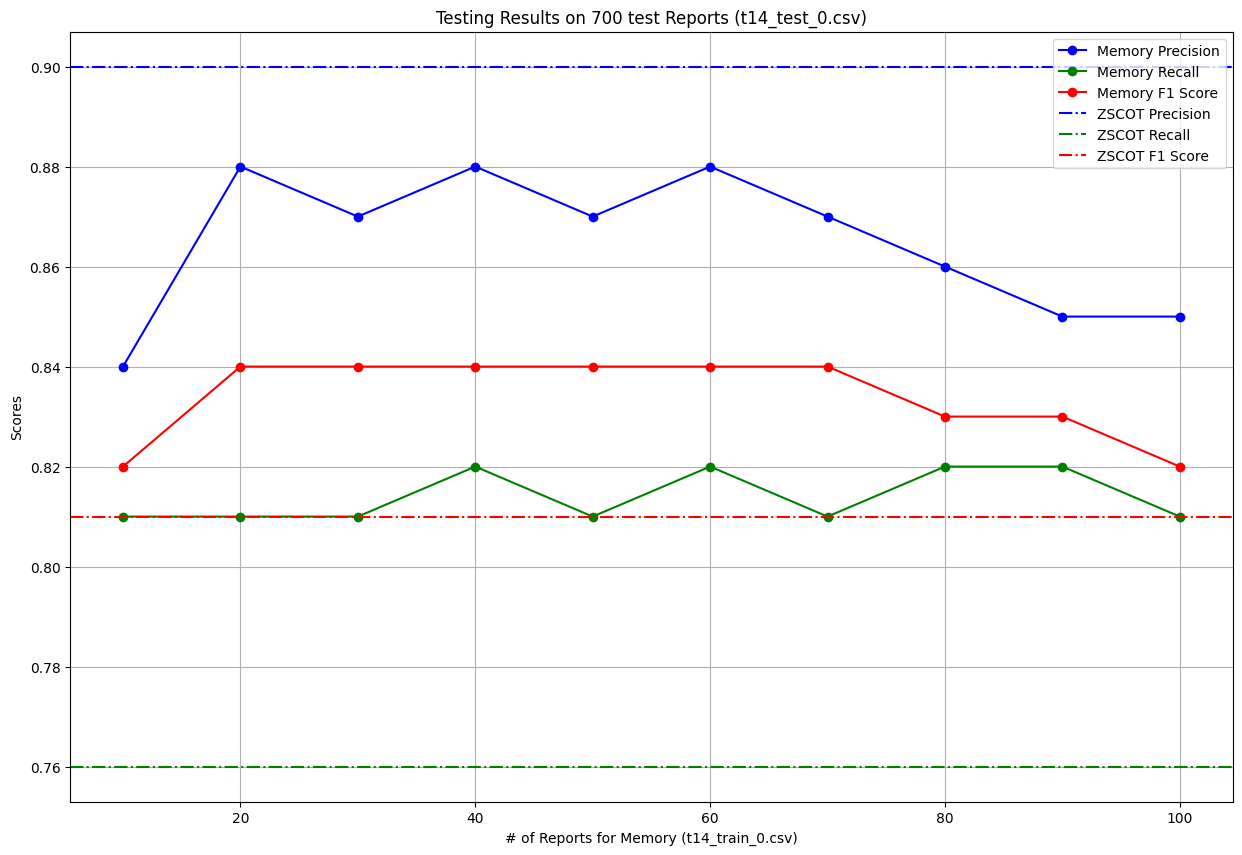

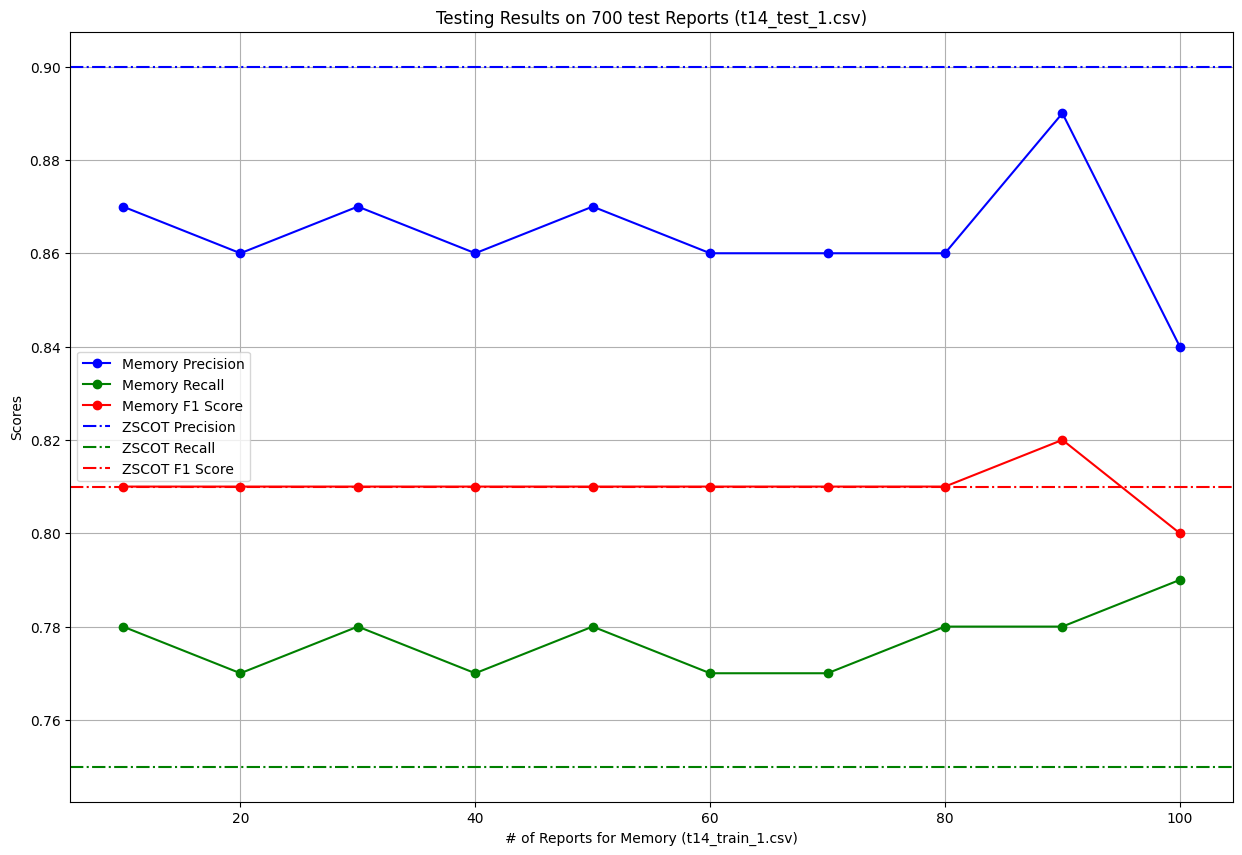

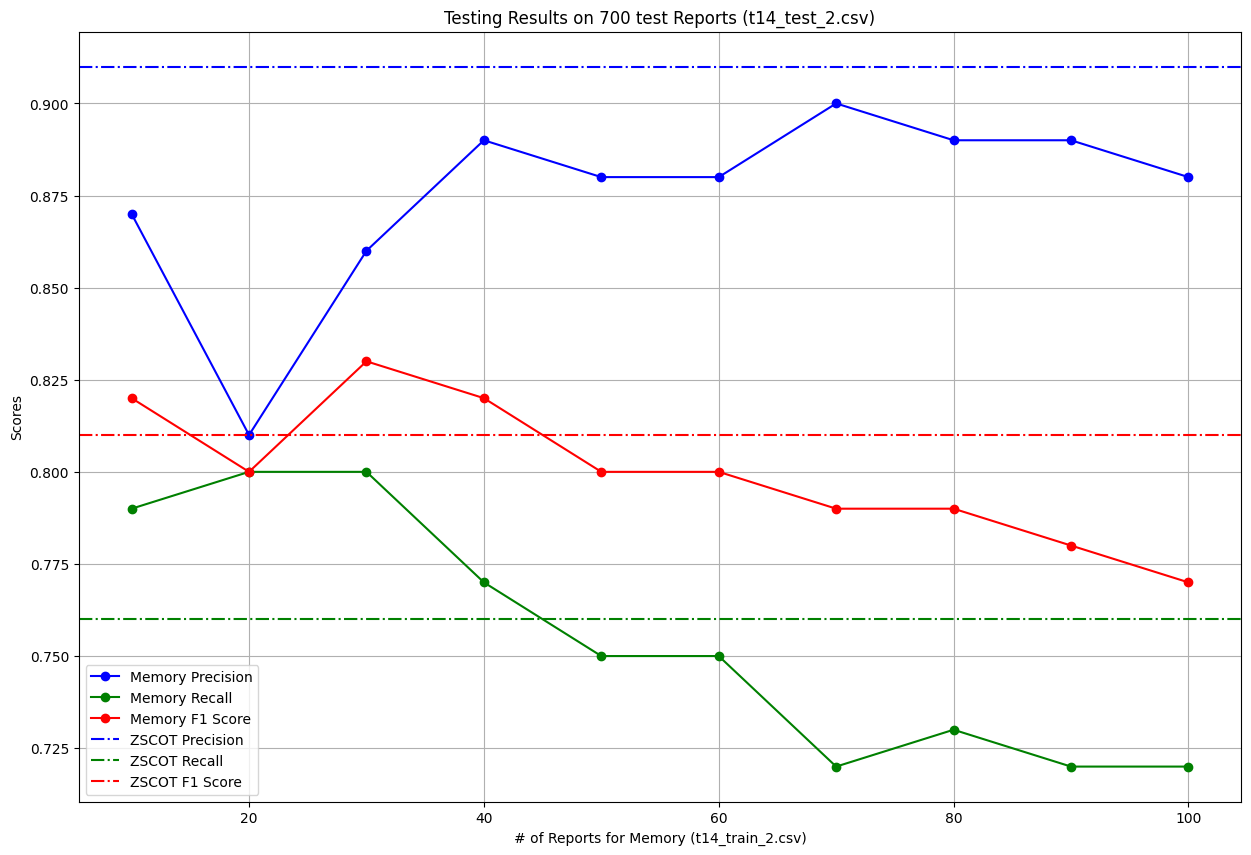

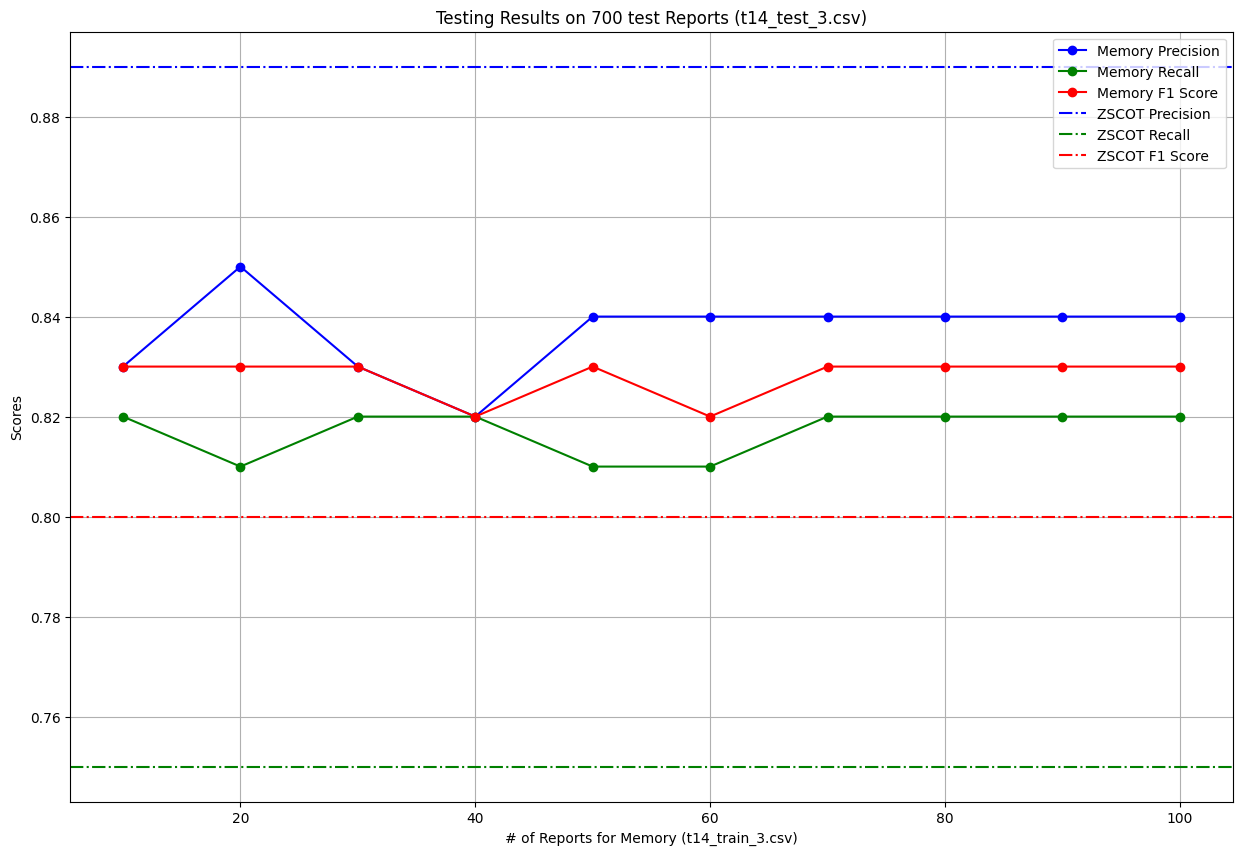

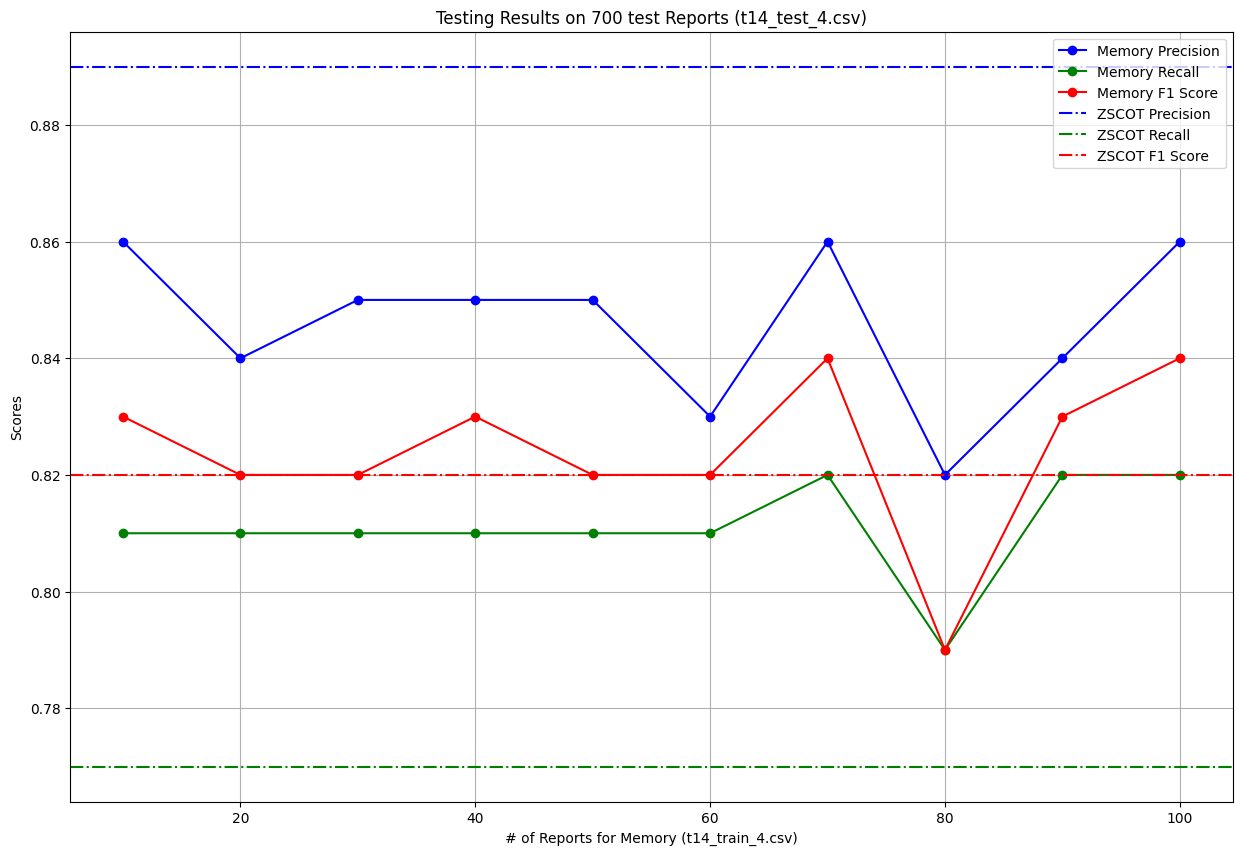

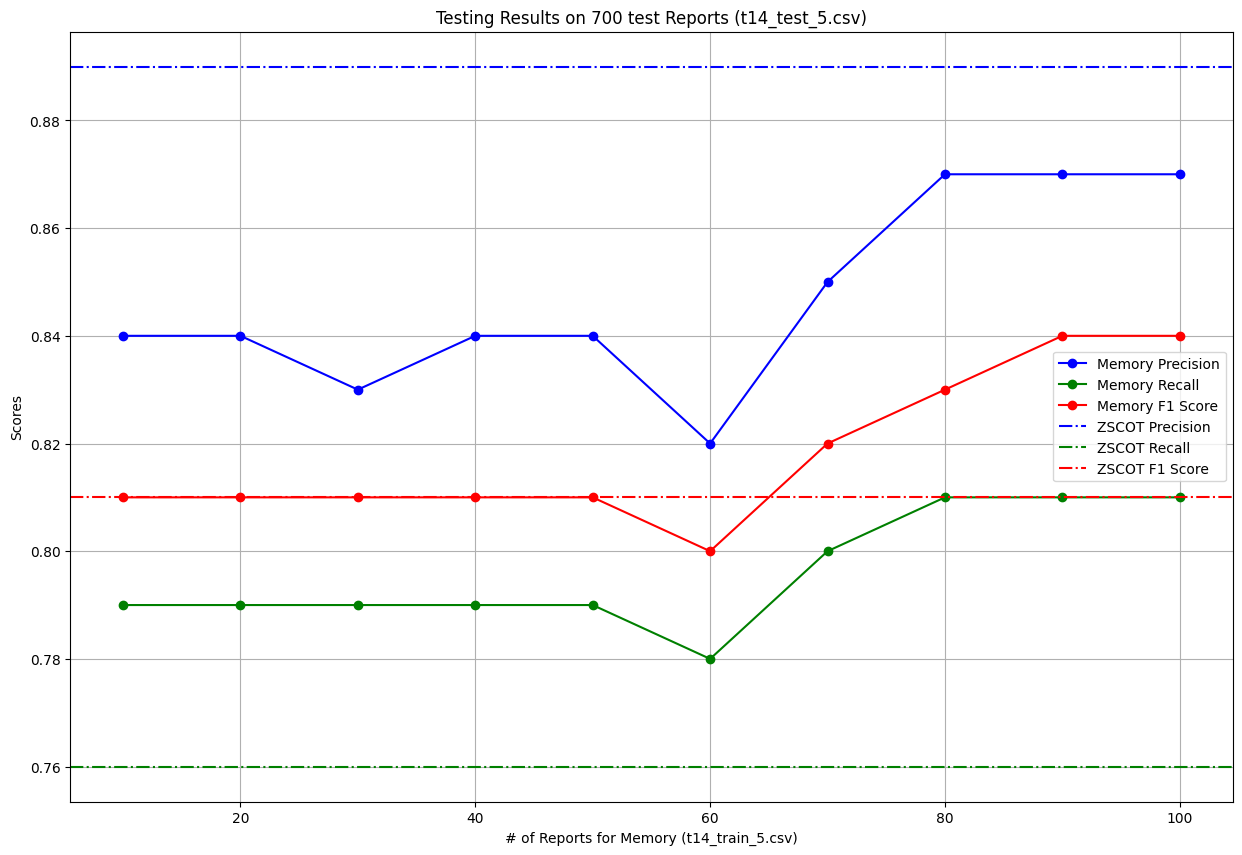

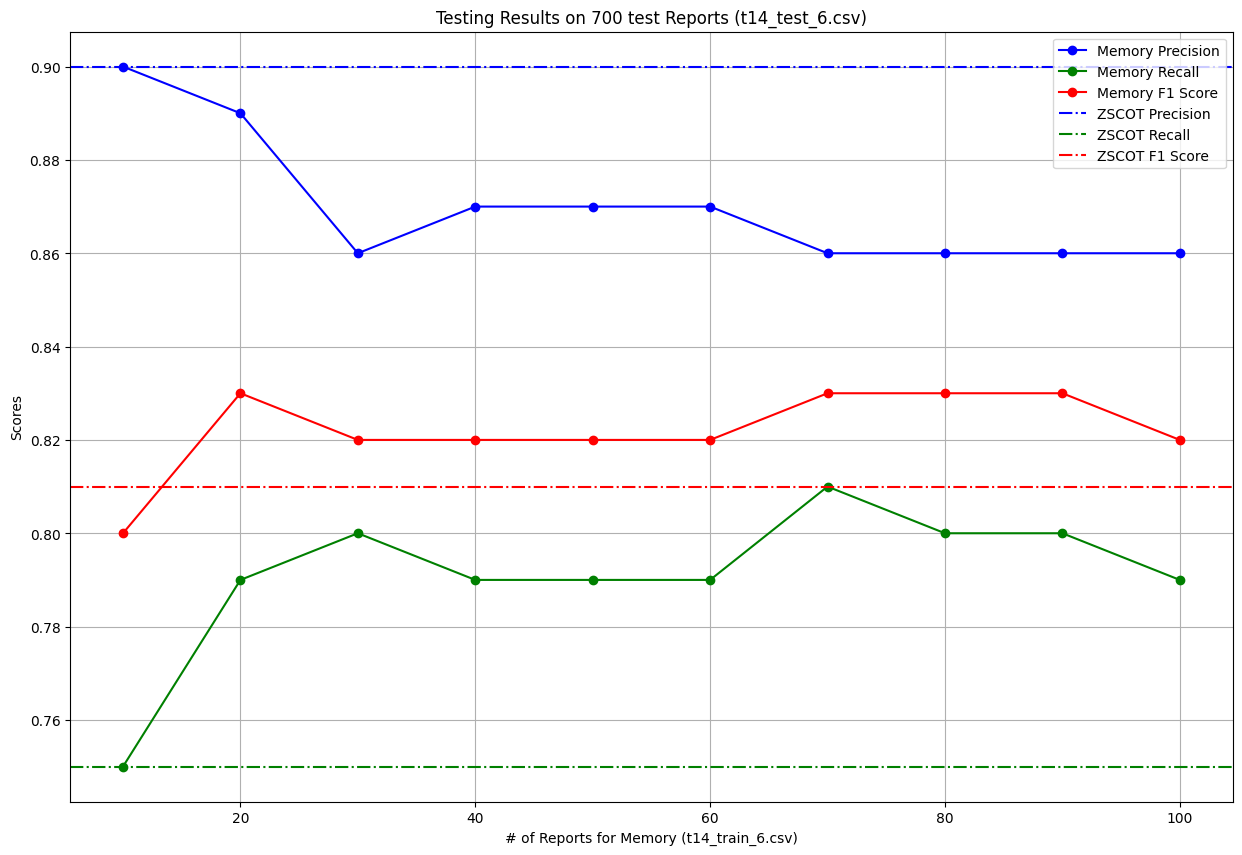

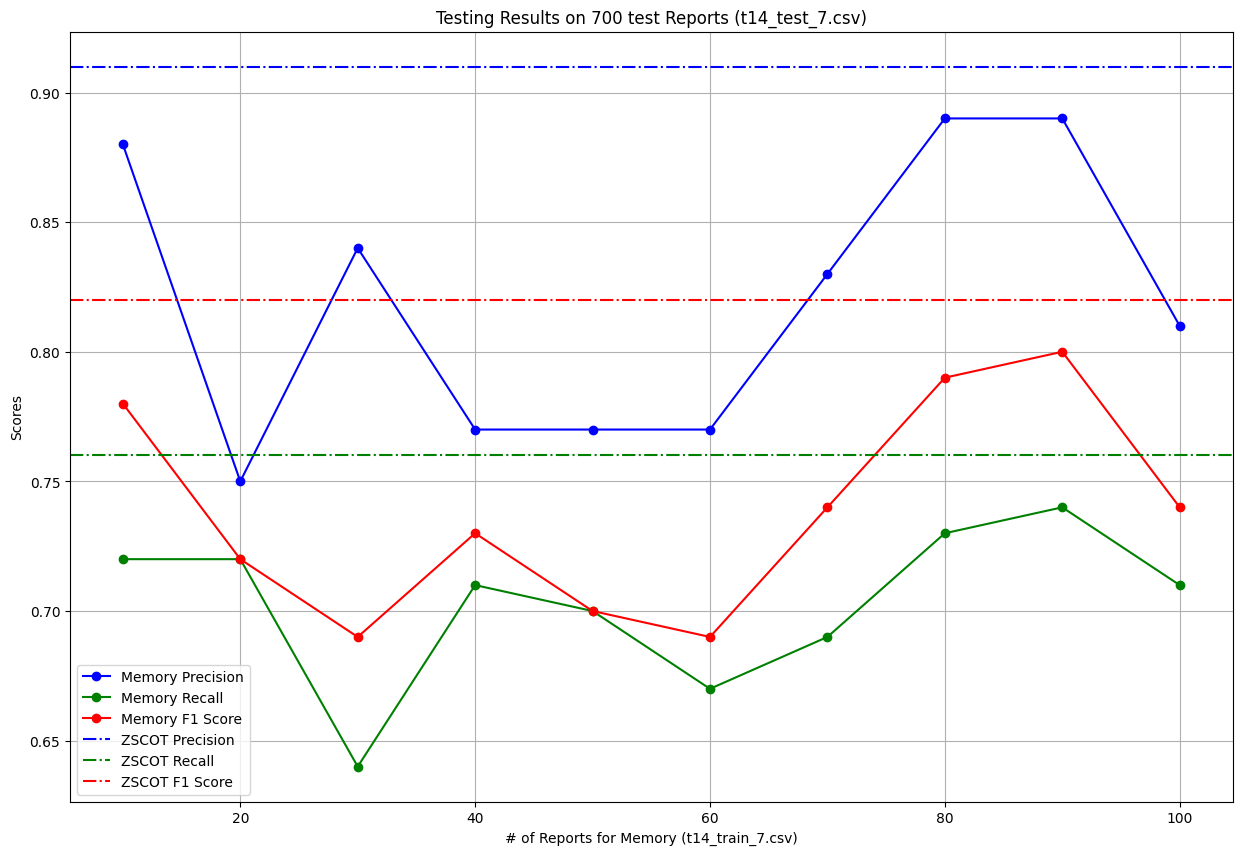

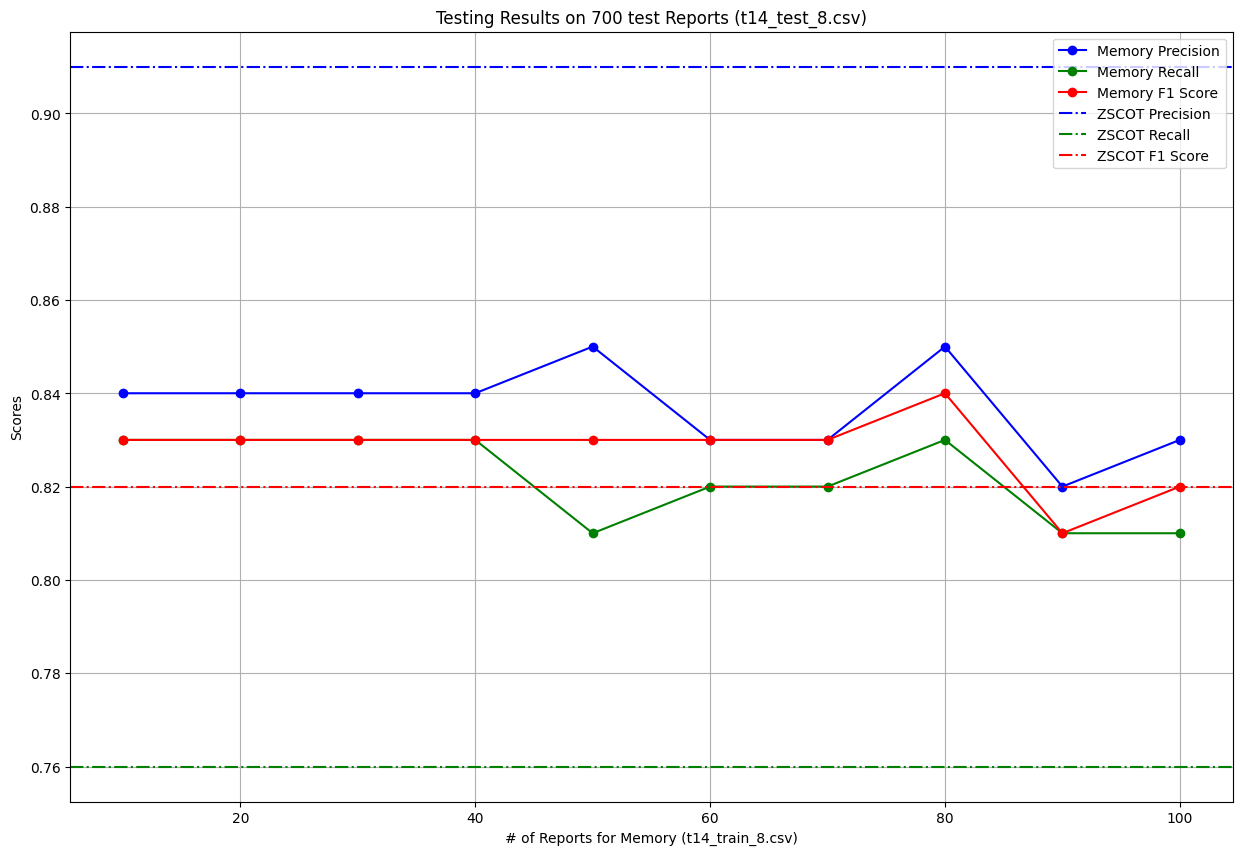

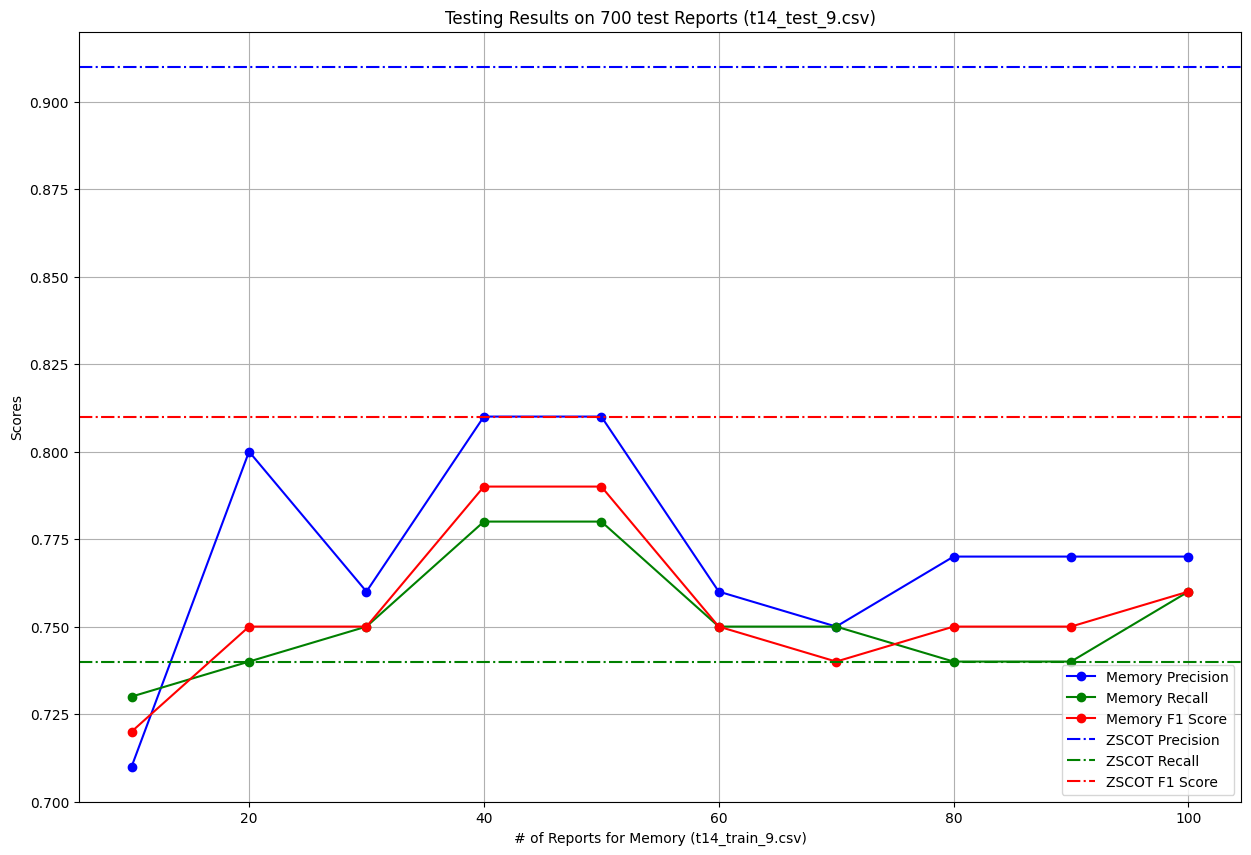

In [34]:
# individual graph

zs_t = pd.read_csv("/home/yl3427/cylab/selfCorrectionAgent/result/0716/t14_real_zs_test_800.csv")
zscot_t = pd.read_csv("/home/yl3427/cylab/selfCorrectionAgent/result/0716/t14_zs_test_800.csv")

for run in range(10):
    # t14 training data to extract memory
    t_train_df = pd.read_csv(f"/home/yl3427/cylab/selfCorrectionAgent/result/t14_memory_dataset{run}.csv")
    memory_tup = []
    for idx, row in t_train_df.iterrows():
        # if row["cmem_t_is_updated"] == True:
        memory_tup.append((idx+1,row['cmem_t_memory_str']))
    memory_tup = memory_tup[9::10]
    test_df = pd.read_csv(f"/home/yl3427/cylab/selfCorrectionAgent/0718_t14_dynamic_test_{run}_outof_10runs.csv")
    split_ids = test_df.patient_filename
    zs_t_split = zs_t[zs_t.patient_filename.isin(split_ids)]
    zscot_t_split = zscot_t[zscot_t.patient_filename.isin(split_ids)]

    for i, _ in memory_tup:
        if len(test_df[test_df[f"cmem_t_{i}reports_is_parsed"]==False]) > 0:
            print(f"parsing error at memory {i}")


   # gather y-axis data
    precision_lst = []
    recall_lst = []
    f1_lst = []

    zs_precision = t14_calculate_metrics(zs_t_split['t'], zs_t_split['zs_t_ans_str'])['overall']['macro_precision']
    zs_recall = t14_calculate_metrics(zs_t_split['t'], zs_t_split['zs_t_ans_str'])['overall']['macro_recall']
    zs_f1 = t14_calculate_metrics(zs_t_split['t'], zs_t_split['zs_t_ans_str'])['overall']['macro_f1']

    zscot_precision = t14_calculate_metrics(zscot_t_split['t'], zscot_t_split['zs_t_ans_str'])['overall']['macro_precision']
    zscot_recall = t14_calculate_metrics(zscot_t_split['t'], zscot_t_split['zs_t_ans_str'])['overall']['macro_recall']
    zscot_f1 = t14_calculate_metrics(zscot_t_split['t'], zscot_t_split['zs_t_ans_str'])['overall']['macro_f1']

    x_idx = []
    for i, _ in memory_tup:
        x_idx.append(i)
        result = t14_calculate_metrics(test_df['t'], test_df[f'cmem_t_{i}reports_ans_str'])['overall']
        precision_lst.append(result['macro_precision'])
        recall_lst.append(result['macro_recall'])
        f1_lst.append(result['macro_f1'])


    plt.figure(figsize=(15, 10))

    plt.plot(x_idx, precision_lst, label='Memory Precision', color='blue', marker='o')
    plt.plot(x_idx, recall_lst, label='Memory Recall', color='green', marker='o')
    plt.plot(x_idx, f1_lst, label='Memory F1 Score', color='red', marker='o')

    # plt.axhline(y=zs_precision, color='blue', linestyle='--', label='ZS Precision')
    # plt.axhline(y=zs_recall, color='green', linestyle='--', label='ZS Recall')
    # plt.axhline(y=zs_f1, color='red', linestyle='--', label='ZS F1 Score')

    plt.axhline(y=zscot_precision, color='blue', linestyle='-.', label='ZSCOT Precision')
    plt.axhline(y=zscot_recall, color='green', linestyle='-.', label='ZSCOT Recall')
    plt.axhline(y=zscot_f1, color='red', linestyle='-.', label='ZSCOT F1 Score')
    
    plt.xlabel(f'# of Reports for Memory (t14_train_{run}.csv)')
    plt.ylabel('Scores')
    plt.title(f'Testing Results on 700 test Reports (t14_test_{run}.csv)')
    plt.legend()
    plt.grid(True)

    plt.show()

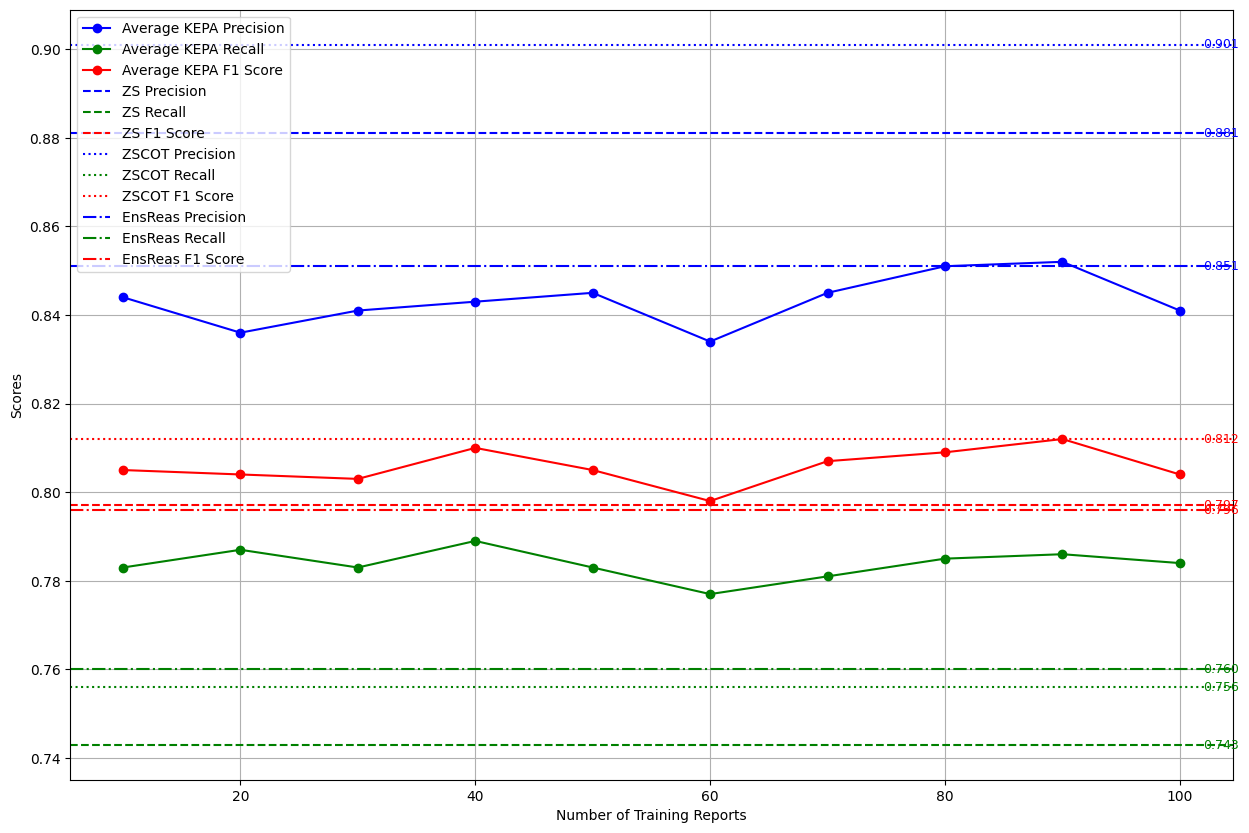

In [46]:
# Average (with new metric)

zs_t = pd.read_csv("/home/yl3427/cylab/selfCorrectionAgent/result/0716/t14_real_zs_test_800.csv")
zscot_t = pd.read_csv("/home/yl3427/cylab/selfCorrectionAgent/result/0716/t14_zs_test_800.csv")
ensReas_t = pd.read_csv("/secure/shared_data/rag_tnm_results/t14_results/mixtral_ensReas_step1/brca_t14_merged_df_800.csv")

zs_t_results = []
zscot_t_results = []
ensReas_t_results = []

total_run = 10
for run in range(total_run):
    split_ids = pd.read_csv(f"/home/yl3427/cylab/selfCorrectionAgent/result/t14_test_{run}.csv").patient_filename
    zs_t_split = zs_t[zs_t.patient_filename.isin(split_ids)]
    zs_t_results.append(t14_calculate_metrics(zs_t_split['t'], zs_t_split['zs_t_ans_str'])['overall'])

    zscot_t_split = zscot_t[zscot_t.patient_filename.isin(split_ids)]
    zscot_t_results.append(t14_calculate_metrics(zscot_t_split['t'], zscot_t_split['zs_t_ans_str'])['overall'])
    
    ensReas_t_split = ensReas_t[ensReas_t.patient_filename.isin(split_ids)]
    ensReas_t_results.append(t14_calculate_metrics(ensReas_t_split['t'], ensReas_t_split['sc_ans'])['overall'])
  
zs_precision_avg = sum([rs['macro_precision'] for rs in zs_t_results])/len(zs_t_results)
zs_recall_avg = sum([rs['macro_recall'] for rs in zs_t_results])/len(zs_t_results)
zs_f1_avg = sum([rs['macro_f1'] for rs in zs_t_results])/len(zs_t_results)

zscot_precision_avg = sum([rs['macro_precision'] for rs in zscot_t_results])/len(zscot_t_results)
zscot_recall_avg = sum([rs['macro_recall'] for rs in zscot_t_results])/len(zscot_t_results)
zscot_f1_avg = sum([rs['macro_f1'] for rs in zscot_t_results])/len(zscot_t_results)

ensReas_precision_avg = sum([rs['macro_precision'] for rs in ensReas_t_results])/len(ensReas_t_results)
ensReas_recall_avg = sum([rs['macro_recall'] for rs in ensReas_t_results])/len(ensReas_t_results)
ensReas_f1_avg = sum([rs['macro_f1'] for rs in ensReas_t_results])/len(ensReas_t_results)


x_axis = np.array(range(1, 11)) * 10

memory_precision_cumulative = []
memory_recall_cumulative = []
memory_f1_cumulative = []


for run in range(total_run):
    test_df = pd.read_csv(f"/home/yl3427/cylab/selfCorrectionAgent/0718_t14_dynamic_test_{run}_outof_10runs.csv")

    for i in np.array(range(1, 11)): # memory (10, 20, 30, 40, 50, 60, 70, 80, 90, 100)
        result = t14_calculate_metrics(test_df['t'], test_df[f'cmem_t_{i*10}reports_ans_str'])['overall']
        if run == 0:
            memory_precision_cumulative.append(result['macro_precision'])
            memory_recall_cumulative.append(result['macro_recall'])
            memory_f1_cumulative.append(result['macro_f1'])
        else:
            memory_precision_cumulative[i-1] += result['macro_precision']
            memory_recall_cumulative[i-1] += result['macro_recall']
            memory_f1_cumulative[i-1] += result['macro_f1']



# average
precision_avg = [p / total_run for p in memory_precision_cumulative]
recall_avg = [r / total_run for r in memory_recall_cumulative]
f1_avg = [f / total_run for f in memory_f1_cumulative]


plt.figure(figsize=(15, 10))

plt.plot(x_axis, precision_avg, label='Average KEPA Precision', color='blue', marker='o')
plt.plot(x_axis, recall_avg, label='Average KEPA Recall', color='green', marker='o')
plt.plot(x_axis, f1_avg, label='Average KEPA F1 Score', color='red', marker='o')


plt.axhline(y=zs_precision_avg, color='blue', linestyle='--', label='ZS Precision')
plt.axhline(y=zs_recall_avg, color='green', linestyle='--', label='ZS Recall')
plt.axhline(y=zs_f1_avg, color='red', linestyle='--', label='ZS F1 Score')

plt.axhline(y=zscot_precision_avg, color='blue', linestyle=':', label='ZSCOT Precision')
plt.axhline(y=zscot_recall_avg, color='green', linestyle=':', label='ZSCOT Recall')
plt.axhline(y=zscot_f1_avg, color='red', linestyle=':', label='ZSCOT F1 Score')

plt.axhline(y=ensReas_precision_avg, color='blue', linestyle='-.', label='EnsReas Precision')
plt.axhline(y=ensReas_recall_avg, color='green', linestyle='-.', label='EnsReas Recall')
plt.axhline(y=ensReas_f1_avg, color='red', linestyle='-.', label='EnsReas F1 Score')

plt.text(x_axis[-1] + 2, zs_precision_avg, f'{zs_precision_avg:.3f}', fontsize=9, ha='left', va='center', color='blue')
plt.text(x_axis[-1] + 2, zs_recall_avg, f'{zs_recall_avg:.3f}', fontsize=9, ha='left', va='center', color='green')
plt.text(x_axis[-1] + 2, zs_f1_avg, f'{zs_f1_avg:.3f}', fontsize=9, ha='left', va='center', color='red')

plt.text(x_axis[-1] + 2, zscot_precision_avg, f'{zscot_precision_avg:.3f}', fontsize=9, ha='left', va='center', color='blue')
plt.text(x_axis[-1] + 2, zscot_recall_avg, f'{zscot_recall_avg:.3f}', fontsize=9, ha='left', va='center', color='green')
plt.text(x_axis[-1] + 2, zscot_f1_avg, f'{zscot_f1_avg:.3f}', fontsize=9, ha='left', va='center', color='red')

plt.text(x_axis[-1] + 2, ensReas_precision_avg, f'{ensReas_precision_avg:.3f}', fontsize=9, ha='left', va='center', color='blue')
plt.text(x_axis[-1] + 2, ensReas_recall_avg, f'{ensReas_recall_avg:.3f}', fontsize=9, ha='left', va='center', color='green')
plt.text(x_axis[-1] + 2, ensReas_f1_avg, f'{ensReas_f1_avg:.3f}', fontsize=9, ha='left', va='center', color='red')

plt.xlabel('Number of Training Reports')
plt.ylabel('Scores')
# plt.title(f'The Average of 10 Results on 700 Test Reports (t14)')
plt.legend()
plt.grid(True)

plt.show()


### N03

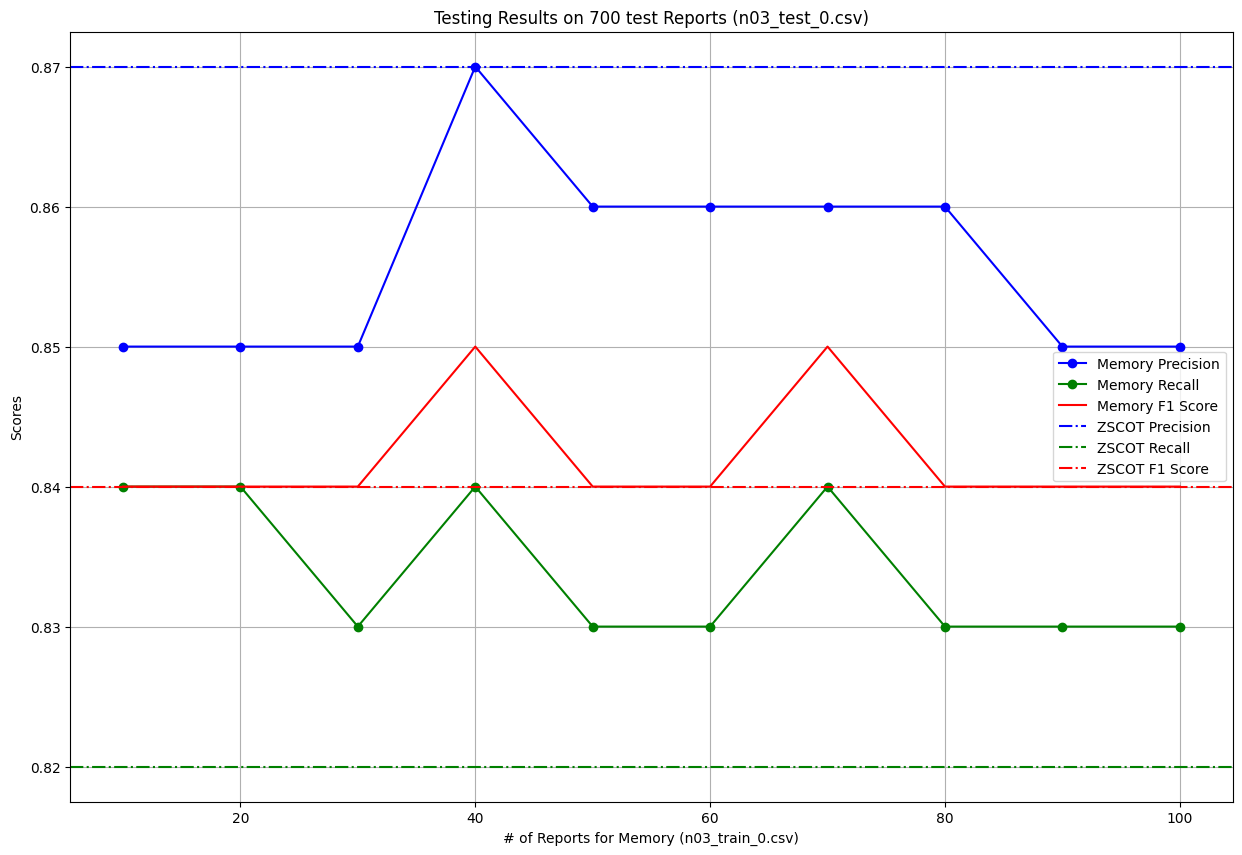

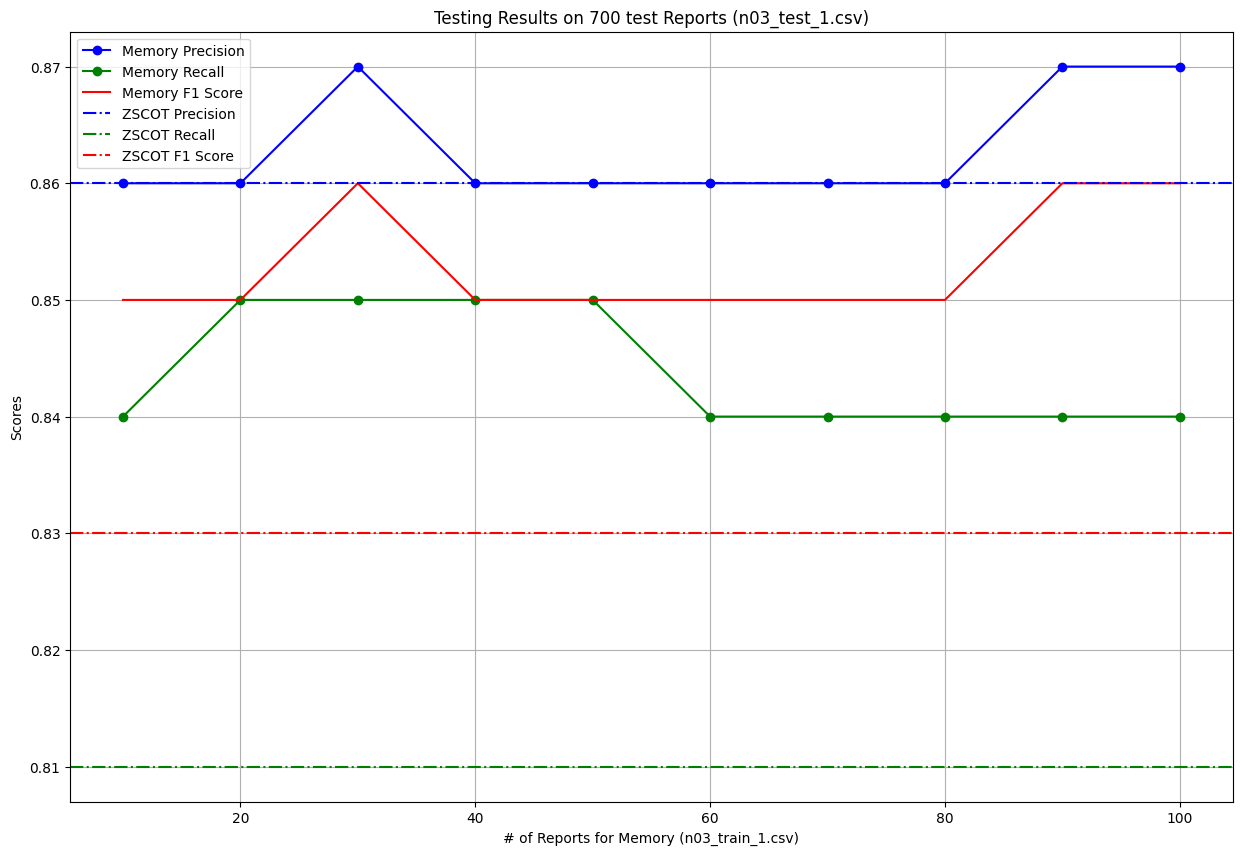

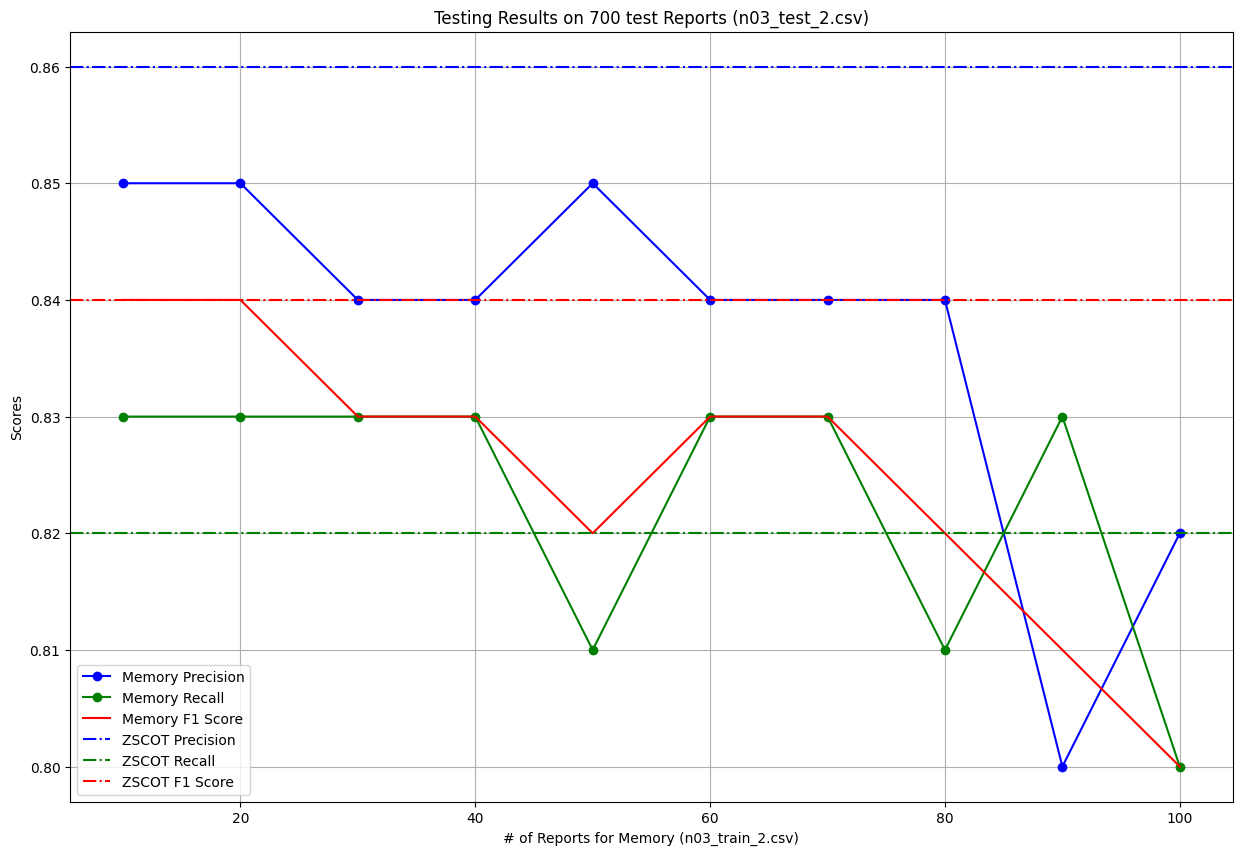

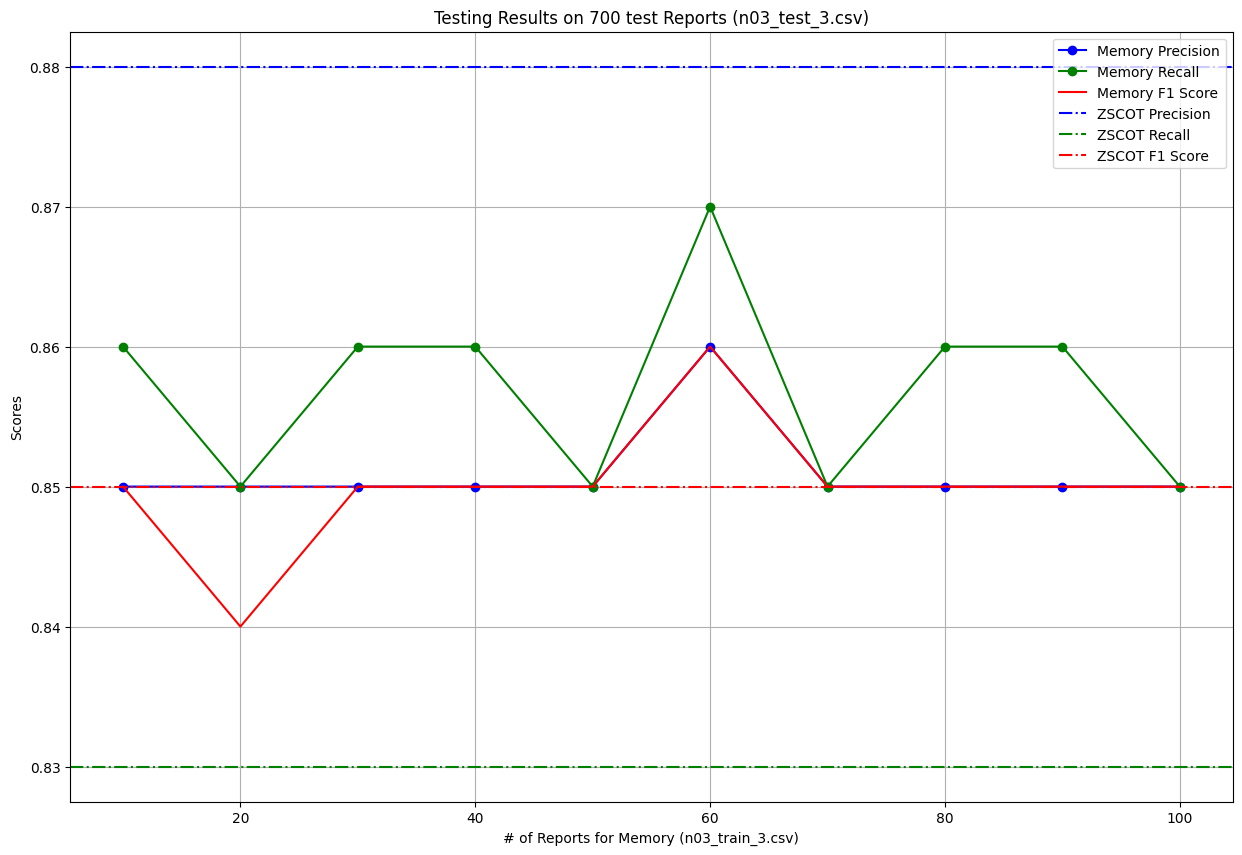

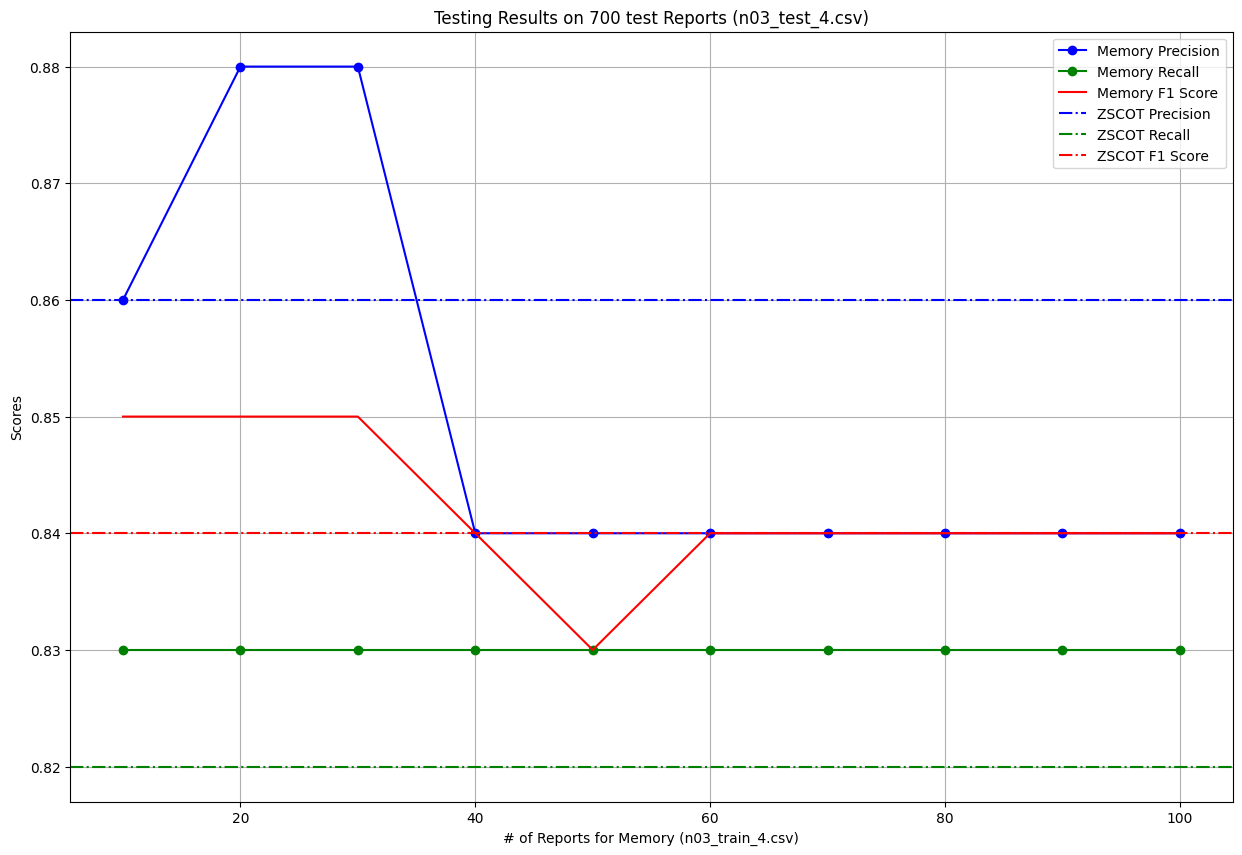

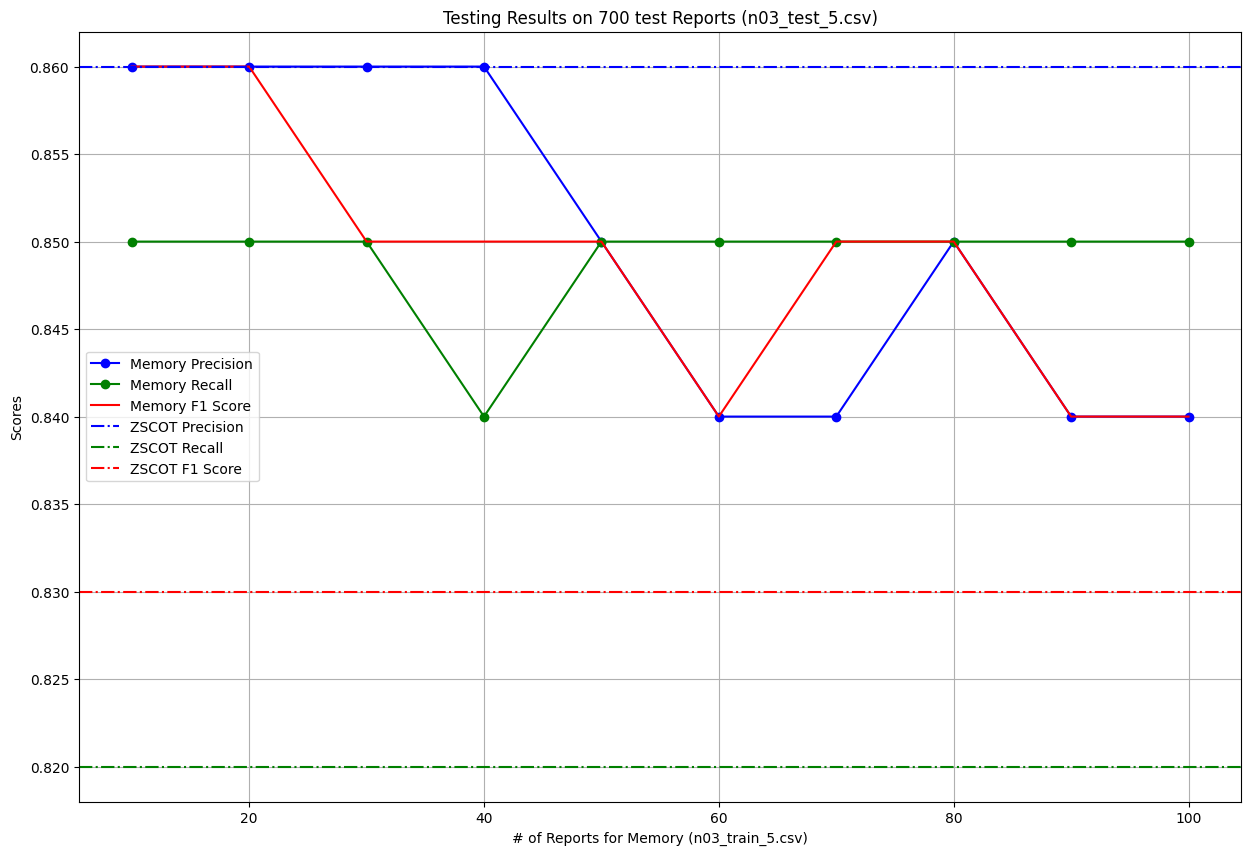

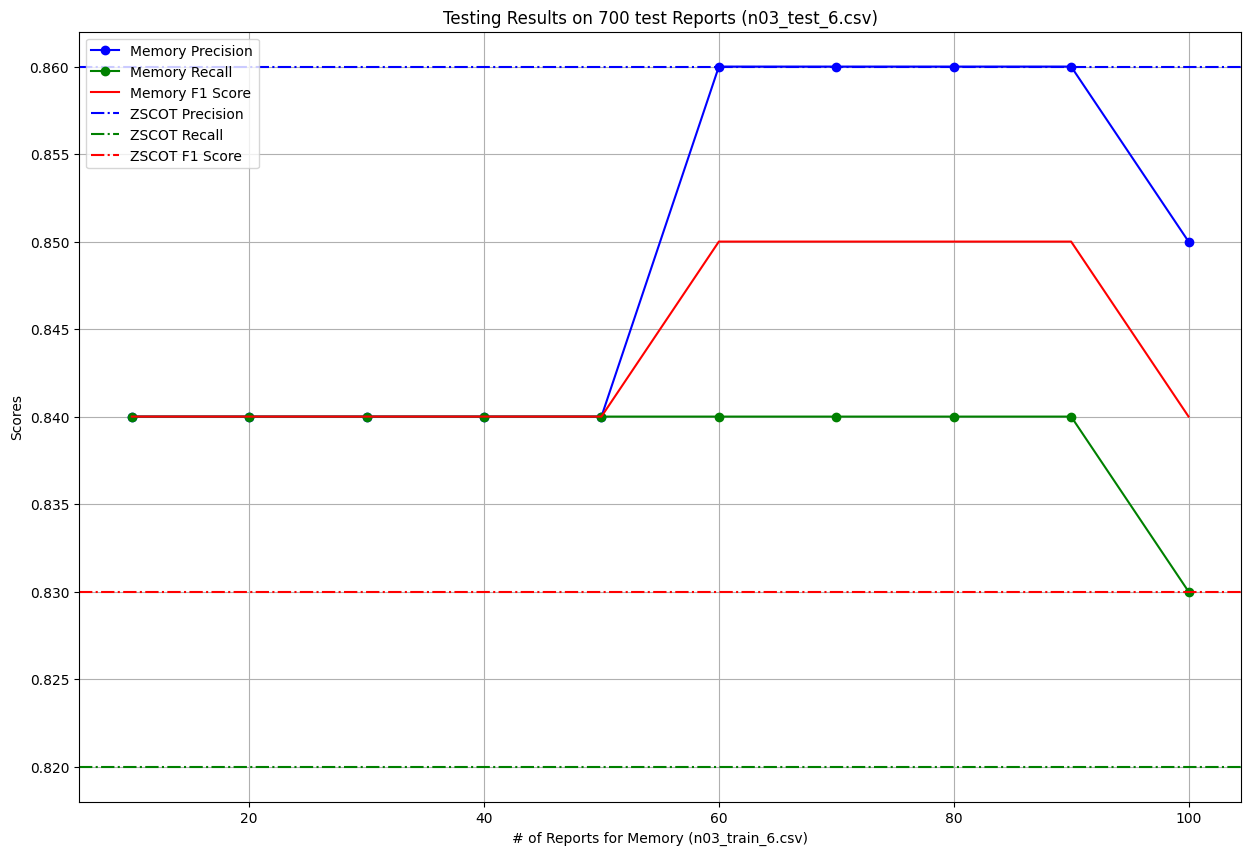

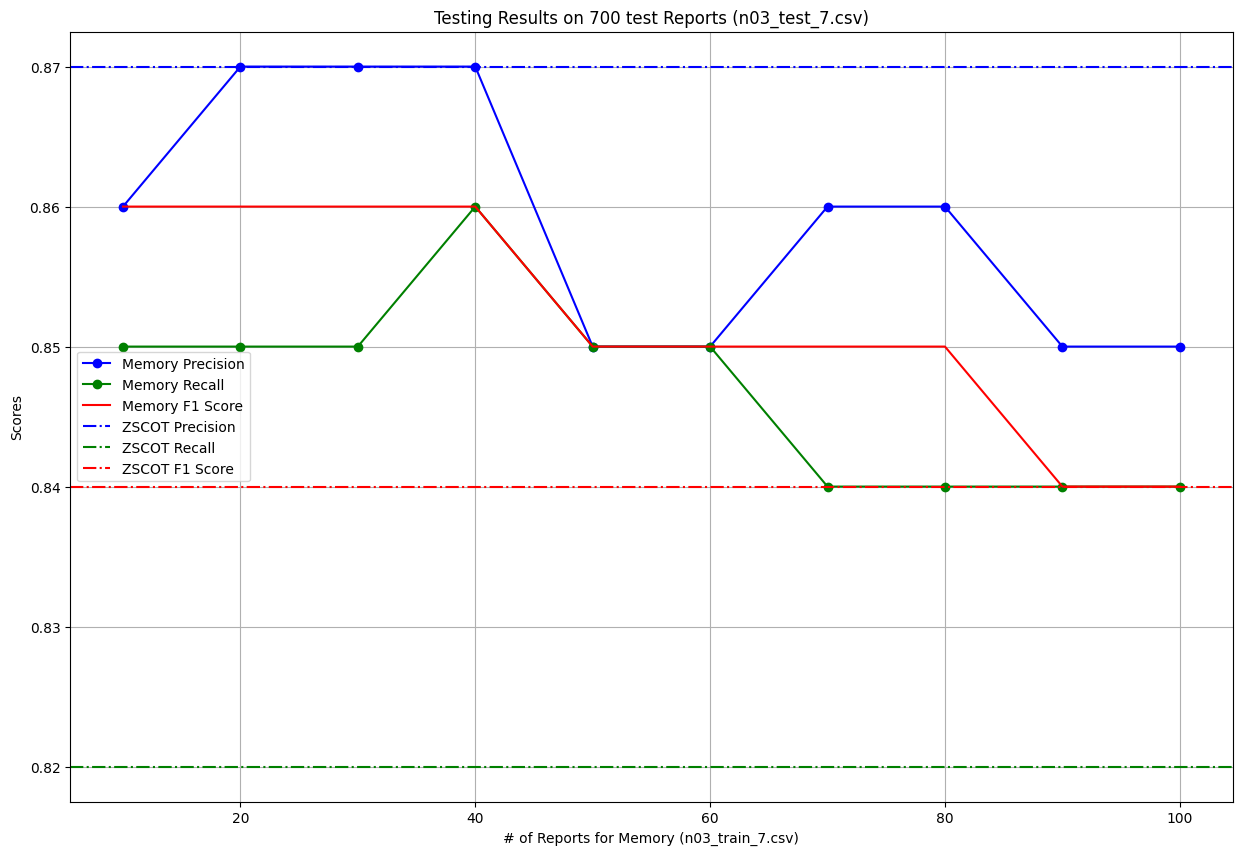

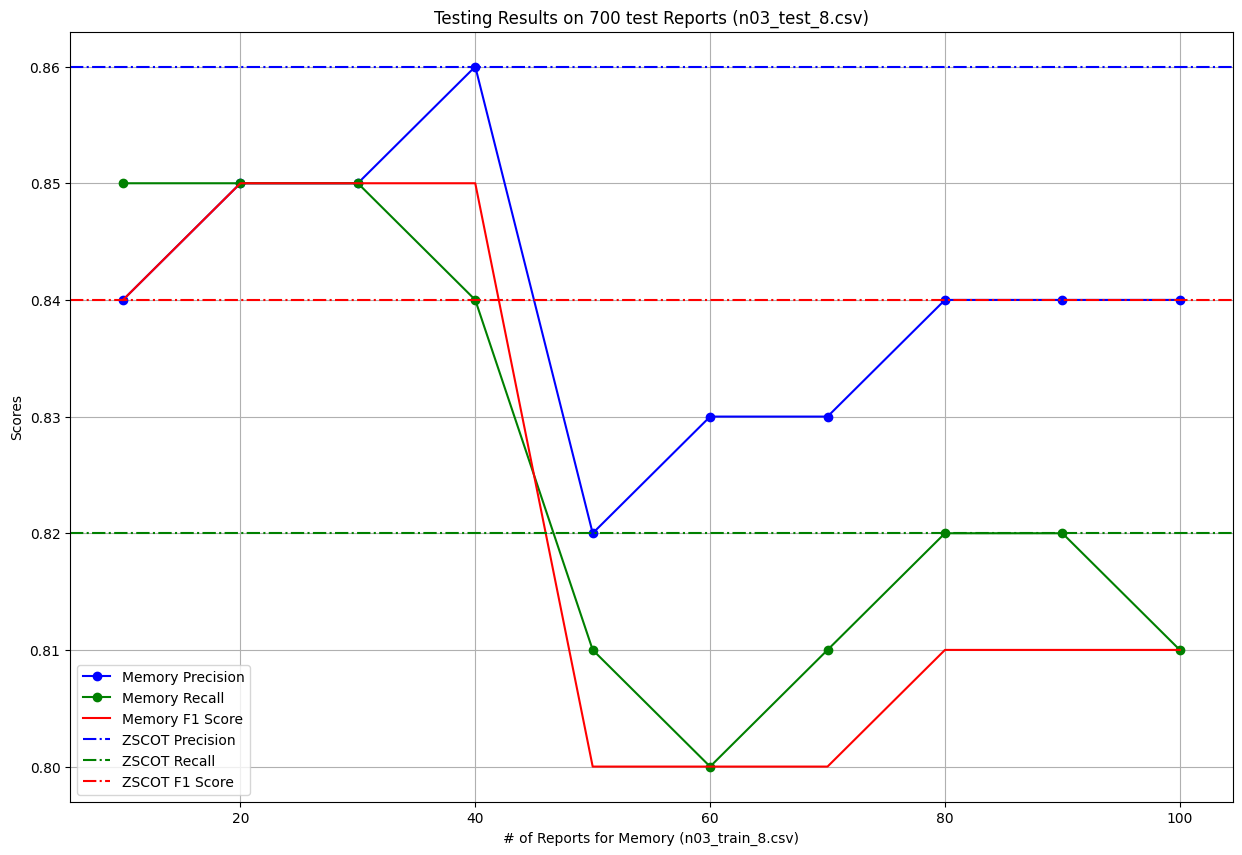

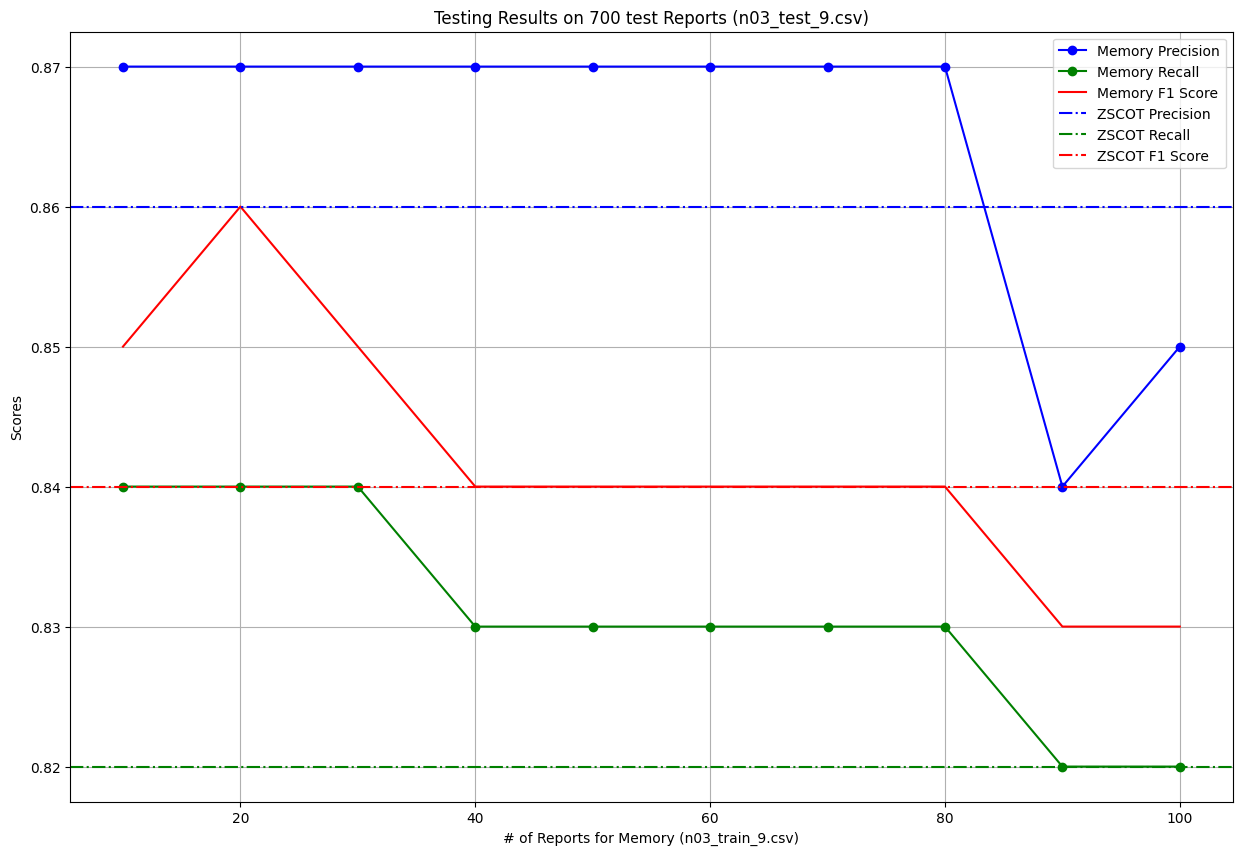

In [36]:
# individual graph

zs_n = pd.read_csv("/home/yl3427/cylab/selfCorrectionAgent/result/0716/n03_real_zs_test_800.csv")
zscot_n = pd.read_csv("/home/yl3427/cylab/selfCorrectionAgent/result/0716/n03_zs_test_800.csv")

for run in range(10):
    # n03 training data to extract memory
    t_train_df = pd.read_csv(f"/home/yl3427/cylab/selfCorrectionAgent/result/n03_memory_dataset{run}.csv")

    memory_tup = []
    for idx, row in t_train_df.iterrows():
        # if row["cmem_t_is_updated"] == True:
        memory_tup.append((idx+1,row['cmem_n_memory_str']))
    memory_tup = memory_tup[9::10]
    test_df = pd.read_csv(f"/home/yl3427/cylab/selfCorrectionAgent/0718_n03_dynamic_test_{run}_outof_10runs.csv")
    split_ids = test_df.patient_filename
    zs_n_split = zs_n[zs_n.patient_filename.isin(split_ids)]
    zscot_n_split = zscot_n[zscot_n.patient_filename.isin(split_ids)]


    for i, _ in memory_tup:
        if len(test_df[test_df[f"cmem_n_{i}reports_is_parsed"]==False]) > 0:
            print(f"parsing error at memory {i}")


   # gather y-axis data
    precision_lst = []
    recall_lst = []
    f1_lst = []

    zs_precision = n03_calculate_metrics(zs_n_split['n'], zs_n_split['zs_n_ans_str'])['overall']['macro_precision']
    zs_recall = n03_calculate_metrics(zs_n_split['n'], zs_n_split['zs_n_ans_str'])['overall']['macro_recall']
    zs_f1 = n03_calculate_metrics(zs_n_split['n'], zs_n_split['zs_n_ans_str'])['overall']['macro_f1']

    zscot_precision = n03_calculate_metrics(zscot_n_split['n'], zscot_n_split['zs_n_ans_str'])['overall']['macro_precision']
    zscot_recall = n03_calculate_metrics(zscot_n_split['n'], zscot_n_split['zs_n_ans_str'])['overall']['macro_recall']
    zscot_f1 = n03_calculate_metrics(zscot_n_split['n'], zscot_n_split['zs_n_ans_str'])['overall']['macro_f1']

    x_idx = []
    for i, _ in memory_tup:
        x_idx.append(i)
        result = n03_calculate_metrics(test_df['n'], test_df[f'cmem_n_{i}reports_ans_str'])['overall']
        precision_lst.append(result['macro_precision'])
        recall_lst.append(result['macro_recall'])
        f1_lst.append(result['macro_f1'])


    plt.figure(figsize=(15, 10))

    plt.plot(x_idx, precision_lst, label='Memory Precision', color='blue', marker='o')
    plt.plot(x_idx, recall_lst, label='Memory Recall', color='green', marker='o')
    plt.plot(x_idx, f1_lst, label='Memory F1 Score', color='red')
    
    # plt.axhline(y=zs_precision, color='blue', linestyle='--', label='ZS Precision')
    # plt.axhline(y=zs_recall, color='green', linestyle='--', label='ZS Recall')
    # plt.axhline(y=zs_f1, color='red', linestyle='--', label='ZS F1 Score')

    plt.axhline(y=zscot_precision, color='blue', linestyle='-.', label='ZSCOT Precision')
    plt.axhline(y=zscot_recall, color='green', linestyle='-.', label='ZSCOT Recall')
    plt.axhline(y=zscot_f1, color='red', linestyle='-.', label='ZSCOT F1 Score')
    
    plt.xlabel(f'# of Reports for Memory (n03_train_{run}.csv)')
    plt.ylabel('Scores')
    plt.title(f'Testing Results on 700 test Reports (n03_test_{run}.csv)')
    plt.legend()
    plt.grid(True)

    plt.show()

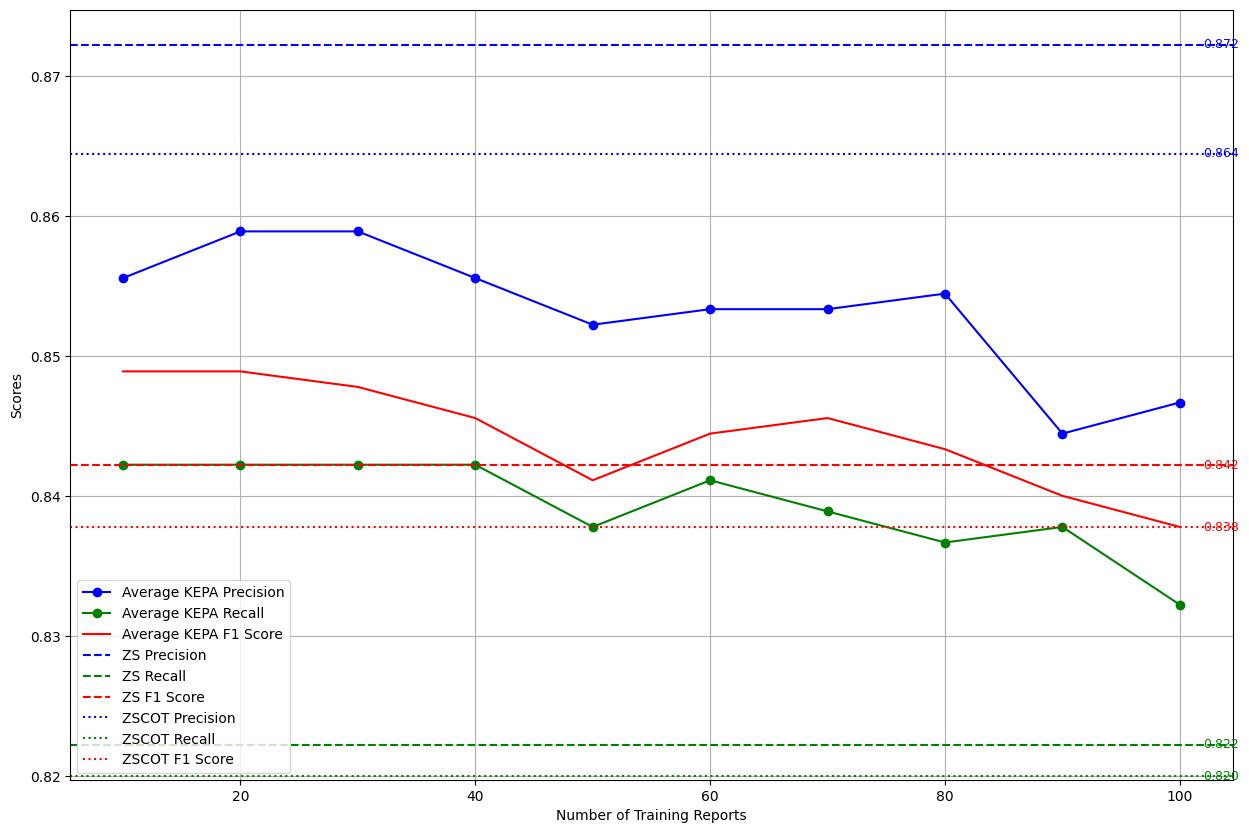

In [37]:
# Average (with new metric)

zs_n = pd.read_csv("/home/yl3427/cylab/selfCorrectionAgent/result/0716/n03_real_zs_test_800.csv")
zscot_n = pd.read_csv("/home/yl3427/cylab/selfCorrectionAgent/result/0716/n03_zs_test_800.csv")
ensReas_n = pd.read_csv("/secure/shared_data/rag_tnm_results/n03_results/mixtral_ensReas_step1/brca_n03_merged_df.csv")

zs_n_results = []
zscot_n_results = []
ensReas_n_results = []

total_run = 10
for run in range(total_run):
    if run == 8:
        continue
    split_ids = pd.read_csv(f"/home/yl3427/cylab/selfCorrectionAgent/result/n03_test_{run}.csv").patient_filename
    zs_n_split = zs_n[zs_n.patient_filename.isin(split_ids)]
    zs_n_results.append(n03_calculate_metrics(zs_n_split['n'], zs_n_split['zs_n_ans_str'])['overall'])

    zscot_n_split = zscot_n[zscot_n.patient_filename.isin(split_ids)]
    zscot_n_results.append(n03_calculate_metrics(zscot_n_split['n'], zscot_n_split['zs_n_ans_str'])['overall'])

    ensReas_n_split = ensReas_n[ensReas_n.patient_filename.isin(split_ids)]
    ensReas_n_results.append(n03_calculate_metrics(ensReas_n_split['n'], ensReas_n_split['sc_ans'])['overall'])

zs_precision_avg = sum([rs['macro_precision'] for rs in zs_n_results])/len(zs_n_results)
zs_recall_avg = sum([rs['macro_recall'] for rs in zs_n_results])/len(zs_n_results)
zs_f1_avg = sum([rs['macro_f1'] for rs in zs_n_results])/len(zs_n_results)

zscot_precision_avg = sum([rs['macro_precision'] for rs in zscot_n_results])/len(zscot_n_results)
zscot_recall_avg = sum([rs['macro_recall'] for rs in zscot_n_results])/len(zscot_n_results)
zscot_f1_avg = sum([rs['macro_f1'] for rs in zscot_n_results])/len(zscot_n_results)

ensReas_precision_avg = sum([rs['macro_precision'] for rs in ensReas_n_results])/len(ensReas_n_results)
ensReas_recall_avg = sum([rs['macro_recall'] for rs in ensReas_n_results])/len(ensReas_n_results)
ensReas_f1_avg = sum([rs['macro_f1'] for rs in ensReas_n_results])/len(ensReas_n_results)


x_axis = np.array(range(1, 11)) * 10

memory_precision_cumulative = []
memory_recall_cumulative = []
memory_f1_cumulative = []
devided_by = 0
for run in range(total_run):
    if run == 8:
        continue
    test_df = pd.read_csv(f"/home/yl3427/cylab/selfCorrectionAgent/0718_n03_dynamic_test_{run}_outof_10runs.csv")

    for i in np.array(range(1, 11)): # memory (10, 20, 30, 40, 50, 60, 70, 80, 90, 100)
        result = n03_calculate_metrics(test_df['n'], test_df[f'cmem_n_{i*10}reports_ans_str'])['overall']
        if run == 0:
            memory_precision_cumulative.append(result['macro_precision'])
            memory_recall_cumulative.append(result['macro_recall'])
            memory_f1_cumulative.append(result['macro_f1'])
        else:
            memory_precision_cumulative[i-1] += result['macro_precision']
            memory_recall_cumulative[i-1] += result['macro_recall']
            memory_f1_cumulative[i-1] += result['macro_f1']
    devided_by += 1


# average
precision_avg = [p / devided_by for p in memory_precision_cumulative]
recall_avg = [r / devided_by for r in memory_recall_cumulative]
f1_avg = [f / devided_by for f in memory_f1_cumulative]


plt.figure(figsize=(15, 10))

plt.plot(x_axis, precision_avg, label='Average KEPA Precision', color='blue', marker='o')
plt.plot(x_axis, recall_avg, label='Average KEPA Recall', color='green', marker='o')
plt.plot(x_axis, f1_avg, label='Average KEPA F1 Score', color='red')


plt.axhline(y=zs_precision_avg, color='blue', linestyle='--', label='ZS Precision')
plt.axhline(y=zs_recall_avg, color='green', linestyle='--', label='ZS Recall')
plt.axhline(y=zs_f1_avg, color='red', linestyle='--', label='ZS F1 Score')

plt.axhline(y=zscot_precision_avg, color='blue', linestyle=':', label='ZSCOT Precision')
plt.axhline(y=zscot_recall_avg, color='green', linestyle=':', label='ZSCOT Recall')
plt.axhline(y=zscot_f1_avg, color='red', linestyle=':', label='ZSCOT F1 Score')

# plt.axhline(y=ensReas_precision_avg, color='blue', linestyle='-.', label='EnsReas Precision')
# plt.axhline(y=ensReas_recall_avg, color='green', linestyle='-.', label='EnsReas Recall')
# plt.axhline(y=ensReas_f1_avg, color='red', linestyle='-.', label='EnsReas F1 Score')

plt.text(x_axis[-1] + 2, zs_precision_avg, f'{zs_precision_avg:.3f}', fontsize=9, ha='left', va='center', color='blue')
plt.text(x_axis[-1] + 2, zs_recall_avg, f'{zs_recall_avg:.3f}', fontsize=9, ha='left', va='center', color='green')
plt.text(x_axis[-1] + 2, zs_f1_avg, f'{zs_f1_avg:.3f}', fontsize=9, ha='left', va='center', color='red')

plt.text(x_axis[-1] + 2, zscot_precision_avg, f'{zscot_precision_avg:.3f}', fontsize=9, ha='left', va='center', color='blue')
plt.text(x_axis[-1] + 2, zscot_recall_avg, f'{zscot_recall_avg:.3f}', fontsize=9, ha='left', va='center', color='green')
plt.text(x_axis[-1] + 2, zscot_f1_avg, f'{zscot_f1_avg:.3f}', fontsize=9, ha='left', va='center', color='red')

# plt.text(x_axis[-1] + 2, ensReas_precision_avg, f'{ensReas_precision_avg:.3f}', fontsize=9, ha='left', va='center', color='blue')
# plt.text(x_axis[-1] + 2, ensReas_recall_avg, f'{ensReas_recall_avg:.3f}', fontsize=9, ha='left', va='center', color='green')
# plt.text(x_axis[-1] + 2, ensReas_f1_avg, f'{ensReas_f1_avg:.3f}', fontsize=9, ha='left', va='center', color='red')

plt.xlabel('Number of Training Reports')
plt.ylabel('Scores')
# plt.title(f'The Average of 10 Results on 700 Test Reports (n03)')
plt.legend()
plt.grid(True)

plt.show()

# Re-run for Error cases

In [ ]:
client = OpenAI(api_key = "empty",
                base_url = "http://localhost:8000/v1")
    
class TestingResponse(BaseModel):
    predictedStage: str = Field(description="predicted cancer stage")
    reasoning: str = Field(description="reasoning to support predicted cancer stage") 

testing_schema = TestingResponse.model_json_schema()

def test_individual_report(dataset: pd.DataFrame, patient_filename: str, memory_tup: tuple, category = 'n'):
    num, memory = memory_tup
    report = dataset[dataset.patient_filename == patient_filename]["text"].values[0]

    if category.lower()[0] == 'n':
        prompt = testing_predict_prompt_n03.format(memory=memory, report=report)
    else:
        prompt = testing_predict_prompt_t14.format(memory=memory, report=report)
    
    prompt = system_instruction + "\n" + prompt
    messages = [{"role": "user", "content": prompt}]
    response = client.chat.completions.create(
        model = "mistralai/Mixtral-8x7B-Instruct-v0.1",
        messages = messages,
        extra_body = {"guided_json": testing_schema},
        temperature = 0.1)
    # response = json.loads(response.choices[0].message.content.replace("\\", "\\\\"))
    response = json.loads(response.choices[0].message.content)

    dataset.loc[dataset["patient_filename"] == patient_filename, f"cmem_{category}_{num}reports_is_parsed"] = True
    dataset.loc[dataset["patient_filename"] == patient_filename, f"cmem_{category}_{num}reports_ans_str"] = response["predictedStage"]
    dataset.loc[dataset["patient_filename"] == patient_filename, f"cmem_{category}_{num}reports_reasoning"] = response["reasoning"]

    return dataset

In [ ]:
# T14
for run in range(10):
    print(f"{run}th split")

    t_train_df = pd.read_csv(f"/home/yl3427/cylab/selfCorrectionAgent/result/t14_memory_dataset{run}.csv")
    memory_tup = []
    for idx, row in t_train_df.iterrows():
        memory_tup.append((idx+1,row['cmem_t_memory_str']))
    memory_tup = memory_tup[9::10]

    test_df = pd.read_csv(f"/home/yl3427/cylab/selfCorrectionAgent/0718_t14_dynamic_test_{run}_outof_10runs.csv")
    for num, memory in memory_tup:
        print(f"{num}th memory")
        for idx in range(len(test_df)):     
            patient_filename = test_df.loc[idx, "patient_filename"]
            if not isinstance(test_df.loc[test_df["patient_filename"] == patient_filename, f"cmem_t_{num}reports_ans_str"].values.item(), str):
                print(idx) 
                print("before: ", test_df.loc[test_df["patient_filename"] == patient_filename, f"cmem_t_{num}reports_ans_str"].values.item())
                test_individual_report(test_df, patient_filename, (num, memory), 't')
                print("after: ", test_df.loc[test_df["patient_filename"] == patient_filename, f"cmem_t_{num}reports_ans_str"].values.item())
                print("label: ", test_df.loc[test_df["patient_filename"] == patient_filename, "t"].values.item())
    
    test_df.to_csv(f"/home/yl3427/cylab/selfCorrectionAgent/0718_t14_dynamic_test_{run}_outof_10runs.csv", index=False)

In [ ]:
# N03
for run in range(10):
    print(f"{run}th split")

    t_train_df = pd.read_csv(f"/home/yl3427/cylab/selfCorrectionAgent/result/n03_memory_dataset{run}.csv")
    memory_tup = []
    for idx, row in t_train_df.iterrows():
        memory_tup.append((idx+1,row['cmem_n_memory_str']))
    memory_tup = memory_tup[9::10]

    test_df = pd.read_csv(f"/home/yl3427/cylab/selfCorrectionAgent/0718_n03_dynamic_test_{run}_outof_10runs.csv")
    for num, memory in memory_tup:
        print(f"{num}th memory")
        for idx in range(len(test_df)):     
            patient_filename = test_df.loc[idx, "patient_filename"]
            if not isinstance(test_df.loc[test_df["patient_filename"] == patient_filename, f"cmem_n_{num}reports_ans_str"].values.item(), str):
                print(idx) 
                print("before: ", test_df.loc[test_df["patient_filename"] == patient_filename, f"cmem_n_{num}reports_ans_str"].values.item())
                test_individual_report(test_df, patient_filename, (num, memory), 'n')
                print("after: ", test_df.loc[test_df["patient_filename"] == patient_filename, f"cmem_n_{num}reports_ans_str"].values.item())
                print("label: ", test_df.loc[test_df["patient_filename"] == patient_filename, "n"].values.item())
    
    test_df.to_csv(f"/home/yl3427/cylab/selfCorrectionAgent/0718_n03_dynamic_test_{run}_outof_10runs.csv", index=False)

In [ ]:
memory_tup

# Check the Difference in Performance Based on the Order of Fields in the Schema

In [ ]:
run = 6
test_df = pd.read_csv(f"/home/yl3427/cylab/selfCorrectionAgent/0718_t14_dynamic_test_{run}_outof_10runs.csv")
for i in np.array(range(1, 11)): # memory (10, 20, 30, 40, 50, 60, 70, 80, 90, 100)
    result = t14_calculate_metrics(test_df['t'], test_df[f'cmem_t_{i*10}reports_ans_str'])['overall']
    print(result)

In [ ]:
run = 6
test_df = pd.read_csv(f"/home/yl3427/cylab/selfCorrectionAgent/0718_t14_dynamic_test_{run}_outof_10runs_revised.csv")
for i in np.array(range(1, 11)): # memory (10, 20, 30, 40, 50, 60, 70, 80, 90, 100)
    if len(test_df[test_df[f"cmem_t_{i*10}reports_is_parsed"]==False]) > 0:
        print(len(test_df[test_df[f"cmem_t_{i*10}reports_is_parsed"]==False]))
    print(t14_calculate_metrics(test_df['t'], test_df[f'cmem_t_{i*10}reports_ans_str'])['overall'])

In [ ]:
n_df = pd.read_csv("/home/yl3427/cylab/selfCorrectionAgent/0718_n03_dynamic_test_5_outof_10runs_reordered.csv")
for i in np.array(range(1, 11)): # memory (10, 20, 30, 40, 50, 60, 70, 80, 90, 100)
    result = n03_calculate_metrics(n_df['n'], n_df[f'cmem_n_{i*10}reports_ans_str'])['overall']
    print(result)

In [ ]:
n_df = pd.read_csv("/home/yl3427/cylab/selfCorrectionAgent/0718_n03_dynamic_test_5_outof_10runs.csv")
for i in np.array(range(1, 11)): # memory (10, 20, 30, 40, 50, 60, 70, 80, 90, 100)
    result = n03_calculate_metrics(n_df['n'], n_df[f'cmem_n_{i*10}reports_ans_str'])['overall']
    print(result)

# Plot Memory length

In [ ]:
# individual memory string length for T14

for i in range(10):
    train_df = pd.read_csv(f"/home/yl3427/cylab/selfCorrectionAgent/result/t14_memory_dataset{i}.csv")
    x_indices = []
    y_str_length_mem = []
    y_str_length_rules = []
 
    for idx, row in train_df.iterrows():
        x_indices.append(idx+1)
        y_str_length_mem.append(len(row['cmem_t_memory_str']))
        y_str_length_rules.append(len(row['cmem_t_rules_str']))
    
    plt.figure(figsize=(15, 10))

    plt.plot(x_indices, y_str_length_mem, label='Memory String Length', color='blue', marker='o')
    plt.plot(x_indices, y_str_length_rules, label='Rules String Length', color='red', marker='o')

    plt.xlabel(f'Index of Memory Dataset (t14_memory_dataset{i}.csv)')
    plt.ylabel('Length')
    # plt.title(f'Length of Memory and Rules')
    plt.legend()
    plt.grid(True)

    plt.show()

In [ ]:
# average memory string length for T14
y_str_length_mem_arr = np.array([0]*100)
y_str_length_rules_arr = np.array([0]*100)
x_indices = np.array(range(1, 101))

for i in range(10):
    train_df = pd.read_csv(f"/home/yl3427/cylab/selfCorrectionAgent/result/t14_memory_dataset{i}.csv")

    for idx, row in train_df.iterrows():
        y_str_length_mem_arr[idx] += len(row['cmem_t_memory_str'])
        y_str_length_rules_arr[idx] += len(row['cmem_t_rules_str']) 

plt.figure(figsize=(15, 10))

plt.plot(x_indices, y_str_length_mem_arr/10, label='Threshold 80', color='blue', marker='o')
plt.plot(x_indices, y_str_length_rules_arr/10, label='Threshold 0', color='red', marker='o')

plt.xlabel(f'Number of Training Reports (T14)')
plt.ylabel('Average Length of Memory')
# plt.title(f'Length of Memory and Rules')
plt.legend()
plt.grid(True)

plt.show()


In [ ]:
# individual number of rules in memory for T14
for i in range(10):
    train_df = pd.read_csv(f"/home/yl3427/cylab/selfCorrectionAgent/result/t14_memory_dataset{i}.csv")
    x_indices = []

    y_num_rules_mem = []
    y_num_rules_rules = []
    for idx, row in train_df.iterrows():
        x_indices.append(idx+1)
        y_num_rules_mem.append(len(row['cmem_t_memory_str'].split("\n")))
        y_num_rules_rules.append(len(row['cmem_t_rules_str'].split("\n")))
    
    plt.figure(figsize=(15, 10))

    plt.plot(x_indices, y_num_rules_mem, label='Memory Num Rules', color='blue', marker='o')
    plt.plot(x_indices, y_num_rules_rules, label='Rules Num Rules', color='red', marker='o')

    plt.xlabel(f'Index of Memory Dataset (t14_memory_dataset{i}.csv)')
    plt.ylabel('Number')
    plt.title(f'Number of Rules')
    plt.legend()
    plt.grid(True)

    max_y = max(max(y_num_rules_mem), max(y_num_rules_rules))
    plt.yticks(range(0, int(max_y) + 1))

    plt.show()

In [ ]:
# average number of rules in memory for T14
y_num_rules_mem_arr = np.array([0]*100)
y_num_rules_rules_arr = np.array([0]*100)
x_indices = np.array(range(1, 101))

for i in range(10):
    train_df = pd.read_csv(f"/home/yl3427/cylab/selfCorrectionAgent/result/t14_memory_dataset{i}.csv")

    for idx, row in train_df.iterrows():
        y_num_rules_mem_arr[idx] += len(row['cmem_t_memory_str'].split("\n"))
        y_num_rules_rules_arr[idx] += len(row['cmem_t_rules_str'].split("\n"))

plt.figure(figsize=(15, 10))

plt.plot(x_indices, y_num_rules_mem_arr/10, label='Threshold 80', color='blue', marker='o')
plt.plot(x_indices, y_num_rules_rules_arr/10, label='Threshold 0', color='red', marker='o')

plt.xlabel(f'Number of Training Reports')
plt.ylabel('Average Number of Rules')

plt.legend()
plt.grid(True)

plt.show()

### n

In [ ]:
# individual memory string length for N03
for i in range(10):
    train_df = pd.read_csv(f"/home/yl3427/cylab/selfCorrectionAgent/result/n03_memory_dataset{i}.csv")
    x_indices = []
    y_str_length_mem = []
    y_str_length_rules = []
 
    for idx, row in train_df.iterrows():
        x_indices.append(idx+1)
        y_str_length_mem.append(len(row['cmem_n_memory_str']))
        y_str_length_rules.append(len(row['cmem_n_rules_str']))
    
    plt.figure(figsize=(15, 10))

    plt.plot(x_indices, y_str_length_mem, label='Memory String Length', color='blue', marker='o')
    plt.plot(x_indices, y_str_length_rules, label='Rules String Length', color='red', marker='o')

    plt.xlabel(f'Index of Memory Dataset (n03_memory_dataset{i}.csv)')
    plt.ylabel('Length')
    # plt.title(f'Length of Memory and Rules')
    plt.legend()
    plt.grid(True)

    plt.show()

In [ ]:
# average memory string length for N03
y_str_length_mem_arr = np.array([0]*100)
y_str_length_rules_arr = np.array([0]*100)
x_indices = np.array(range(1, 101))

for i in range(10):
    train_df = pd.read_csv(f"/home/yl3427/cylab/selfCorrectionAgent/result/n03_memory_dataset{i}.csv")

    for idx, row in train_df.iterrows():
        y_str_length_mem_arr[idx] += len(row['cmem_n_memory_str'])
        y_str_length_rules_arr[idx] += len(row['cmem_n_rules_str']) 

plt.figure(figsize=(15, 10))

plt.plot(x_indices, y_str_length_mem_arr/10, label='Threshold 80', color='blue', marker='o')
plt.plot(x_indices, y_str_length_rules_arr/10, label='Threshold 0', color='red', marker='o')

plt.xlabel(f'Number of Training Reports (N03)')
plt.ylabel('Average Length of Memory')
# plt.title(f'Length of Memory and Rules')
plt.legend()
plt.grid(True)

plt.show()


# Create format instruction

In [4]:
class TrainingResponse(BaseModel):
    reasoning: str = Field(description="reasoning to support predicted cancer stage")
    predictedStage: str = Field(description="predicted cancer stage")
    rules: List[str] = Field(description="list of rules") 

class TestingResponse(BaseModel):
    reasoning: str = Field(description="reasoning to support predicted cancer stage") 
    predictedStage: str = Field(description="predicted cancer stage")
     

In [6]:
type(TrainingResponse.model_json_schema())

dict

In [ ]:
parser = PydanticOutputParser(pydantic_object=TestingResponse)
format_instruction=parser.get_format_instructions()
print(type(format_instruction))
print(format_instruction)

In [ ]:
res=TestingResponse.model_validate_json('{\n  "predictedStage": "T2",\n  "reasoning": "The largest dimension of the tumor is 3.7 cm, which falls within the range for T2 (greater than 2 cm but not greater than 5 cm)."\n}')

In [ ]:
res.reasoning